In [1]:
# Variable params to variate with Papermill
string_test = "4paper_test01_15x2_9btsp_24ph_v20"
hours_before = 24 # How many hours of pollution data are we adding as input to the model (current - hours_before)
bootstrap = True
boostrap_factor = 15  # Number of times to repeat the bootstrap
boostrap_threshold = 2.9


In [2]:
# Fixed params not varied with Papermill

In [3]:
import os
import pickle
import sys
import time
from datetime import date, datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from pandas import DataFrame
from sklearn import preprocessing

from ai_common.constants.AI_params import NormParams, TrainingParams, ModelParams
import ai_common.training.trainingutils as utilsNN
from ai_common.models.modelSelector import select_1d_model
from conf.MakeWRF_and_DB_CSV_UserConfiguration import getPreprocWRFParams
from conf.TrainingUserConfiguration import getTrainingParams
from conf.localConstants import constants
from conf.params import LocalTrainingParams, PreprocParams
from os.path import join
from proj_io.inout import create_folder, add_forecasted_hours, add_previous_hours, filter_data, get_column_names, read_merged_files, save_columns
from proj_preproc.preproc import apply_bootstrap, normalizeData
from viz.figure_generator import plot_input_output_data


# Filtering warnings:
import warnings

warnings.filterwarnings("ignore", message="DataFrame is highly fragmented")
warnings.simplefilter(action='ignore', category=pd.core.common.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', 'SettingWithCopyWarning')
warnings.filterwarnings('ignore', category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = filter out INFO, 2 = filter out WARNING and INFO, 3 = filter out ERROR, WARNING, and INFO


In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

In [5]:
config = getTrainingParams()
stations = config[LocalTrainingParams.stations]
pollutants = config[LocalTrainingParams.pollutants]
start_year = 2010
end_year = 2019
cur_pollutant = 'otres'
cur_station = 'MER'

input_folder = config[TrainingParams.input_folder]
output_folder = config[TrainingParams.output_folder]
output_folder = join(output_folder,F"{string_test}_{start_year}_{end_year}")
val_perc = config[TrainingParams.validation_percentage]
test_perc = config[TrainingParams.test_percentage]
eval_metrics = config[TrainingParams.evaluation_metrics]
loss_func = config[TrainingParams.loss_function]
batch_size = config[TrainingParams.batch_size]
epochs = config[TrainingParams.epochs]
model_name_user = config[TrainingParams.config_name]
optimizer = config[TrainingParams.optimizer]
forecasted_hours = config[LocalTrainingParams.forecasted_hours]
norm_type = config[TrainingParams.normalization_type]

split_info_folder = join(output_folder, 'Splits')
parameters_folder = join(output_folder, 'Parameters')
weights_folder = join(output_folder, 'models')
logs_folder = join(output_folder, 'logs')
imgs_folder= join(output_folder, 'imgs')
norm_folder = join(output_folder, 'norm')

create_folder(split_info_folder)
create_folder(parameters_folder)
create_folder(weights_folder)
create_folder(logs_folder)
create_folder(norm_folder)
create_folder(imgs_folder)

In [6]:
input_folder = config[TrainingParams.input_folder]
data = read_merged_files(input_folder, start_year, end_year)
config[ModelParams.INPUT_SIZE] = len(data.columns)

datetimes_str = data.index.values
datetimes = np.array([datetime.strptime(x, constants.datetime_format.value) for x in datetimes_str])

Reading years 2010 to 2019...
============ Reading data for: 2010: /ZION/AirPollutionData/Data/MergedDataCSV/16/2010_AllStations.csv
============ Reading data for: 2011: /ZION/AirPollutionData/Data/MergedDataCSV/16/2011_AllStations.csv
============ Reading data for: 2012: /ZION/AirPollutionData/Data/MergedDataCSV/16/2012_AllStations.csv
============ Reading data for: 2013: /ZION/AirPollutionData/Data/MergedDataCSV/16/2013_AllStations.csv
============ Reading data for: 2014: /ZION/AirPollutionData/Data/MergedDataCSV/16/2014_AllStations.csv
============ Reading data for: 2015: /ZION/AirPollutionData/Data/MergedDataCSV/16/2015_AllStations.csv
============ Reading data for: 2016: /ZION/AirPollutionData/Data/MergedDataCSV/16/2016_AllStations.csv
============ Reading data for: 2017: /ZION/AirPollutionData/Data/MergedDataCSV/16/2017_AllStations.csv
============ Reading data for: 2018: /ZION/AirPollutionData/Data/MergedDataCSV/16/2018_AllStations.csv
============ Reading data for: 2019: /ZION/

In [7]:
now = datetime.utcnow().strftime("%Y_%m_%d_%H_%M")
model_name = F'{model_name_user}_{cur_pollutant}_{now}'
file_name_norm = join(norm_folder,F"{model_name}_scaler.pkl")  
print("Normalizing data....")
data_norm_df = normalizeData(data, norm_type, file_name_norm)

Normalizing data....


Scaler/normalizer object saved to: /ZION/AirPollutionData/Data/TrainingTestsOZ/4paper_test01_15x2_9btsp_24ph_v20_2010_2019/norm/TestOZ_otres_2024_01_25_21_20_scaler.pkl
Done! Current shape: (87658, 2925) 


In [8]:
all_contaminant_columns, all_meteo_columns, all_time_colums = get_column_names(data_norm_df)

In [9]:
# Here we remove all the data of other pollutants
X_df = filter_data(data_norm_df, filter_type='single_pollutant',
                   filtered_pollutant=cur_pollutant) 

print(X_df.columns.values)
print(F'X {X_df.shape}, Memory usage: {X_df.memory_usage().sum()/1024**2:02f} MB')

Keeping columns: 2730 original columns: 2925
['cont_otres_UIZ' 'cont_otres_AJU' 'cont_otres_ATI' ... 'GLW_13_h23'
 'GLW_14_h23' 'GLW_15_h23']
X (87658, 2730), Memory usage: 1826.431259 MB


In [10]:
print(F"Building X and Y ....")
X_df = add_previous_hours(X_df, hours_before=hours_before)

Building X and Y ....
	Adding the previous hours of the pollutants as additional columns...


X (87658, 3450), Memory usage: 2307.951035 MB
Done!


In [11]:
print("\tAdding the forecasted hours of the pollutant as the predicted column Y...")
Y_df = add_forecasted_hours(X_df, cur_pollutant, range(1,forecasted_hours+1))

	Adding the forecasted hours of the pollutant as the predicted column Y...
Shape of Y: (87658, 720)
Done!


In [12]:
X_df = X_df.iloc[hours_before:,:]
Y_df = Y_df.iloc[hours_before:,:]
save_columns(Y_df, join(output_folder, 'Y_columns.csv'))
save_columns(X_df, join(output_folder, 'X_columns.csv'))
print("Done!")

print(F'Original {data_norm_df.shape}')
print(F'X {X_df.shape}, Memory usage: {X_df.memory_usage().sum()/1024**2:02f} MB')
print(F'Y {Y_df.shape}, Memory usage: {Y_df.memory_usage().sum()/1024**2:02f} MB')

Done saving file: /ZION/AirPollutionData/Data/TrainingTestsOZ/4paper_test01_15x2_9btsp_24ph_v20_2010_2019/Y_columns.csv
Done saving file: /ZION/AirPollutionData/Data/TrainingTestsOZ/4paper_test01_15x2_9btsp_24ph_v20_2010_2019/X_columns.csv
Done!
Original (87658, 2925)
X (87634, 3450), Memory usage: 2307.319138 MB
Y (87634, 720), Memory usage: 482.056534 MB


In [13]:
print("Splitting training and validation data by year....")

splits_file = join(split_info_folder, F'splits_{model_name}.csv')
train_idxs, val_idxs, test_idxs = utilsNN.split_train_validation_and_test(
    len(X_df), val_perc, test_perc, shuffle_ids=False, file_name=splits_file)

Splitting training and validation data by year....
Saving split information...


In [14]:
# Here we remove the datetime indexes so we need to consider that 
print("Removing time index...")
X_df.reset_index(drop=True, inplace=True)
Y_df.reset_index(drop=True, inplace=True)

X_df_train = X_df.iloc[train_idxs]
Y_df_train = Y_df.iloc[train_idxs]

X_df_val = X_df.iloc[val_idxs]
Y_df_val = Y_df.iloc[val_idxs]

print(F'X train {X_df_train.shape}, Memory usage: {X_df_train.memory_usage().sum()/1024**2:02f} MB')
print(F'Y train {Y_df_train.shape}, Memory usage: {Y_df_train.memory_usage().sum()/1024**2:02f} MB')
print(F'X val {X_df_val.shape}, Memory usage: {X_df_val.memory_usage().sum()/1024**2:02f} MB')
print(F'Y val {Y_df_val.shape}, Memory usage: {Y_df_val.memory_usage().sum()/1024**2:02f} MB')

print("Done!")

Removing time index...
X train (78870, 3450), Memory usage: 2076.571426 MB
Y train (78870, 720), Memory usage: 433.847580 MB
X val (8764, 3450), Memory usage: 230.747711 MB
Y val (8764, 720), Memory usage: 48.208954 MB
Done!


In [15]:
if bootstrap:
    # -------- Bootstrapping the data
    # Se utiliza esta estacion para decidir que indices son los que se van a usar para el bootstrapping.
    # Only the indexes for this station that are above the threshold will be used for bootstrapping
    station = "MER" 
    print("Bootstrapping the data...")
    print(F'X train {X_df_train.shape}, Memory usage: {X_df_train.memory_usage().sum()/1024**2:02f} MB')
    print(F'Y train {Y_df_train.shape}, Memory usage: {Y_df_train.memory_usage().sum()/1024**2:02f} MB')
    X_df_train, Y_df_train = apply_bootstrap(X_df_train, Y_df_train, cur_pollutant, station, boostrap_threshold, forecasted_hours, boostrap_factor)
    print(F'X train bootstrapped {X_df_train.shape}, Memory usage: {X_df_train.memory_usage().sum()/1024**2:02f} MB')
    print(F'Y train bootstrapped {Y_df_train.shape}, Memory usage: {Y_df_train.memory_usage().sum()/1024**2:02f} MB')
    print(F'X val {X_df_val.shape}, Memory usage: {X_df_val.memory_usage().sum()/1024**2:02f} MB')
    print(F'Y val {Y_df_val.shape}, Memory usage: {Y_df_val.memory_usage().sum()/1024**2:02f} MB')

Bootstrapping the data...
X train (78870, 3450), Memory usage: 2076.571426 MB
Y train (78870, 720), Memory usage: 433.847580 MB
Bootstrapping the data...
X train bootstrapped (238455, 3450), Memory usage: 6278.291359 MB
Y train bootstrapped (238455, 720), Memory usage: 1311.691704 MB
X val (8764, 3450), Memory usage: 230.747711 MB
Y val (8764, 720), Memory usage: 48.208954 MB


In [16]:
replace_value = 0
print(f"Replacing nan values with {replace_value}...")
X_df_train.fillna(replace_value, inplace=True)
X_df_val.fillna(replace_value, inplace=True)
Y_df_train.fillna(replace_value, inplace=True)
Y_df_val.fillna(replace_value, inplace=True)

Replacing nan values with 0...


In [17]:
#print("Visualizing input and outputs...")
#plot_input_output_data(X_df_train, Y_df_train, cur_station, cur_pollutant, 
#                       imgs_folder, model_name)

In [17]:
print(f"Train examples: {X_df_train.shape[0]}")
print(f"Validation examples {X_df_val.shape[0]}")

# ******************* Selecting the model **********************
config[ModelParams.INPUT_SIZE] = X_df_train.shape[1]
config[ModelParams.NUMBER_OF_OUTPUT_CLASSES] = Y_df_train.shape[1]

model = select_1d_model(config)
print("Done!")


#print("Getting callbacks ...")
all_callbacks = utilsNN.get_all_callbacks(model_name=model_name,
                                           early_stopping_func=F'val_{eval_metrics[0].__name__}',
                                             weights_folder=weights_folder,
                                             patience=50,
                                             logs_folder=logs_folder)

print("Compiling model ...")
model.compile(loss=loss_func, optimizer=optimizer, metrics=eval_metrics)
model.summary()

Train examples: 238455
Validation examples 8764
Done!
The early stopping callback is in auto mode
Compiling model ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3450)]            0         
                                                                 
 input_layer (Dense)         (None, 300)               1035300   
                                                                 
 hidden_1 (Dense)            (None, 300)               90300     
                                                                 
 batch_normalization (BatchN  (None, 300)              1200      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 hidden_2

In [18]:

print("Training ...")
model.fit(X_df_train.values, Y_df_train.values,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_df_val.values, Y_df_val.values),
                    shuffle=True,
                    callbacks=all_callbacks)

Training ...
Epoch 1/5000
48/48 [==============================] - 5s 76ms/step - loss: 1.3488 - mean_squared_error: 1.3488 - val_loss: 0.6218 - val_mean_squared_error: 0.6218 - lr: 1.0000e-04
Epoch 2/5000
48/48 [==============================] - 3s 55ms/step - loss: 0.8205 - mean_squared_error: 0.8205 - val_loss: 0.6046 - val_mean_squared_error: 0.6046 - lr: 1.0000e-04
Epoch 3/5000
48/48 [==============================] - 3s 52ms/step - loss: 0.6668 - mean_squared_error: 0.6668 - val_loss: 0.5535 - val_mean_squared_error: 0.5535 - lr: 1.0000e-04
Epoch 4/5000
48/48 [==============================] - 2s 47ms/step - loss: 0.6058 - mean_squared_error: 0.6058 - val_loss: 0.4492 - val_mean_squared_error: 0.4492 - lr: 1.0000e-04
Epoch 5/5000
48/48 [==============================] - 2s 46ms/step - loss: 0.5678 - mean_squared_error: 0.5678 - val_loss: 0.3697 - val_mean_squared_error: 0.3697 - lr: 1.0000e-04
Epoch 6/5000
48/48 [==============================] - 3s 64ms/step - loss: 0.5365 - mea

# Evaluation after training

In [20]:
from copy import copy
training_results_folder = f'{output_folder}' # copied this way on train-evaluation run,  otherwise on only evaluation something like...'/ZION/AirPollutionData/Data/TrainingTestsPS/test01_15x3_5btsp_24ph_2010_2019' #
INPUT_SIZE = copy(config[ModelParams.INPUT_SIZE])


In [21]:
print(training_results_folder,INPUT_SIZE, sep="\n")


/ZION/AirPollutionData/Data/TrainingTestsOZ/4paper_test01_15x2_9btsp_24ph_v20_2010_2019
3450


In [22]:
#%%
import glob
import os
import sys
import time
from copy import deepcopy
from datetime import date, datetime, timedelta
from os import listdir
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
from pandas import DataFrame
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

from ai_common.constants.AI_params import *
from ai_common.models.modelSelector import select_1d_model
from AI.data_generation.utilsDataFormat import *
from conf.TrainingUserConfiguration import get_makeprediction_config
from conf.localConstants import constants
from conf.params import LocalTrainingParams
from proj_io.inout import create_folder, filter_data, add_previous_hours, add_forecasted_hours, get_column_names
from proj_preproc.preproc import loadScaler, extract_model_name
from proj_prediction.prediction import analyze_column, scatter_plot_by_column, compile_scaler, average_metric, average_metric_by_hour, analyze_multi_hour_plot, plot_max_difference, plot_forecast_hours, plot_max_and_mean_difference, calculate_imeca
from viz.figure_generator import plot_input_output_data

# import seaborn as sns
# import matplotlib
# matplotlib.use('Agg')  # Set up Matplotlib to use backend 'Agg' supress plot windows in batchmodes


In [23]:
# In case we want to save the columns to temporal files for debugging purposes
os.environ["CUDA_VISIBLE_DEVICES"] = "" # No  CUDA on evaluation, not needed in general

config = get_makeprediction_config()
# *********** Reads the parameters ***********

input_file = config[ClassificationParams.input_file]
output_folder = config[ClassificationParams.output_folder]
output_imgs_folder = config[ClassificationParams.output_imgs_folder]
output_file_name = config[ClassificationParams.output_file_name]
model_weights_file = config[ClassificationParams.model_weights_file]
forecasted_hours = config[LocalTrainingParams.forecasted_hours]
pollutant = config[LocalTrainingParams.pollutants][0]

# ********** Reading and preprocessing data *******
all_stations = [
    "UIZ", "AJU", "ATI", "CUA", "SFE", "SAG", "CUT", "PED", "TAH", "GAM",
    "IZT", "CCA", "HGM", "LPR", "MGH", "CAM", "FAC", "TLA", "MER", "XAL",
    "LLA", "TLI", "UAX", "BJU", "MPA", "MON", "NEZ", "INN", "AJM", "VIF"
]

evaluate_stations = ["UIZ", "AJU", "ATI", "UAX"]
evaluate_hours = [1, 6, 12, 18, 24]

# Iterate over the stations
models_folder = '/ZION/AirPollutionData/Data/Training/cont_otres_UIZ/models/'
data_folder = '/ZION/AirPollutionData/Data/MergedDataCSV/16/'

test_year = 2019

# %%
# cur_station is now a fixed value
cur_station = 'MER' # just to infer some statistics 


# %% Extract model name from weights file_names.hdf5
models_path = join(training_results_folder, 'models')
model_name = extract_model_name(models_path)
print(model_name)

# file with testing data
hardcoded_input_file = '/ZION/AirPollutionData/Data/MergedDataCSV/16/2019_AllStations.csv'

# path to normalization data
norm_folder = join(training_results_folder,'norm')

imgs_folder = training_results_folder

path_csvs = training_results_folder

#hours_before = 0 # now it is readed from training...

print(f"""training_results_folder:{training_results_folder}
model_name:{model_name}
hardcoded_input_file:{hardcoded_input_file}
norm_folder:{norm_folder}
imgs_folder:{imgs_folder}
path_csvs:{path_csvs}
""")


print(f"""input_file:{input_file}
output_folder:{output_folder}
output_imgs_folder:{output_imgs_folder}
output_file_name:{output_file_name}
model_weights_file:{model_weights_file}
forecasted_hours:{forecasted_hours}
pollutant:{pollutant}
""")


TestOZ_otres_2024_01_19_22_05
training_results_folder:/ZION/AirPollutionData/Data/TrainingTestsOZ/4paper_test01_15x2_9btsp_24ph_v20_2010_2019
model_name:TestOZ_otres_2024_01_19_22_05
hardcoded_input_file:/ZION/AirPollutionData/Data/MergedDataCSV/16/2019_AllStations.csv
norm_folder:/ZION/AirPollutionData/Data/TrainingTestsOZ/4paper_test01_15x2_9btsp_24ph_v20_2010_2019/norm
imgs_folder:/ZION/AirPollutionData/Data/TrainingTestsOZ/4paper_test01_15x2_9btsp_24ph_v20_2010_2019
path_csvs:/ZION/AirPollutionData/Data/TrainingTestsOZ/4paper_test01_15x2_9btsp_24ph_v20_2010_2019

input_file:/ZION/AirPollutionData/Data/MergedDataCSV/16/2015_cont_otres_AllStations.csv
output_folder:/ZION/AirPollutionData/Data/Results
output_imgs_folder:/ZION/AirPollutionData/Data/Results/TestOZ
output_file_name:/ZION/AirPollutionData/TrainingTESTOZ/Results/TestOZ.csv
model_weights_file:/ZION/AirPollutionData/TrainingTESTOZ/models
forecasted_hours:24
pollutant:otres



In [24]:
# %% Definir o cargar los folder donde se exportaran imágenes y datos

output_results_folder = join(output_imgs_folder, model_name)
output_results_folder_img = join(output_results_folder, 'imgs')
output_results_folder_data = join(output_results_folder, 'data')

create_folder(output_results_folder)
create_folder(output_results_folder_img)
create_folder(output_results_folder_data)


In [25]:

model_name_user = config[TrainingParams.config_name]
print(f'model_name_user: {model_name_user}')
print(f'output_folder: {output_folder}')


model_name_user: TestOZ
output_folder: /ZION/AirPollutionData/Data/Results


In [26]:
#%% Loading the best weight file on the weights folder

path_model_weights = join(f'{training_results_folder}',f'models')
print(f'\nModel weight file to use: \n\n {path_model_weights}\n\n')

model_weights_file = join(path_model_weights,f'{model_name}*')
weight_files = glob.glob(model_weights_file)
lista_weights =[]
for item in weight_files:
    lista_weights.append(float(item.split('/')[-1].split('-')[-1].split('.hdf5')[0]))
print(f'Weighs on dir:{lista_weights}')
model_weights_file = glob.glob(join(path_model_weights,f'{model_name}*{min(lista_weights)}*'))
model_weights_file = model_weights_file[0]
print(f'\nModel weight file to use of    {min(lista_weights)}: \n\n',model_weights_file)



Model weight file to use: 

 /ZION/AirPollutionData/Data/TrainingTestsOZ/4paper_test01_15x2_9btsp_24ph_v20_2010_2019/models


Weighs on dir:[0.6170435, 0.58144557, 0.52940625, 0.42668545, 0.35524201, 0.32327899, 0.31246829, 0.30658108, 0.30194521, 0.29588869, 0.29147896, 0.28725898, 0.28371775, 0.27962747, 0.27742404, 0.27627948, 0.27417359, 0.27345878, 0.27071443, 0.26812977, 0.26760328, 0.26562431, 0.2634874, 0.26280171, 0.26138049, 0.25954714, 0.2574884, 0.25681114]

Model weight file to use of    0.25681114: 

 /ZION/AirPollutionData/Data/TrainingTestsOZ/4paper_test01_15x2_9btsp_24ph_v20_2010_2019/models/TestOZ_otres_2024_01_19_22_05-epoch-40-loss-0.25681114.hdf5


In [27]:
# Selects the proper model file for the current station
assert len(model_weights_file) > 0
assert len(input_file) > 0

print(F"input file:\n\n {input_file}\n")

input file:

 /ZION/AirPollutionData/Data/MergedDataCSV/16/2015_cont_otres_AllStations.csv



In [28]:
#%% data test file
input_file = hardcoded_input_file
data = pd.read_csv(input_file, index_col=0)

In [29]:
#%% Redo the test dataset data as in the hotvectors used during training.
datetimes_str = data.index.values
datetimes = np.array([
    datetime.strptime(x, constants.datetime_format.value)
    for x in datetimes_str
])


In [30]:
# %% -------- Normalizing data
# loading original scaler object
file_name_norm = join(norm_folder,F"{model_name}_scaler.pkl")  
scaler = loadScaler(file_name_norm)

# %% generating an scaler according to data
new_scaler_cols = data.columns.tolist()
old_features = scaler.feature_names_in_.tolist()
#print(old_features)

# %%
# desired prefix
prefijo = 'plusfake_x_'
new_scaler_cols = [prefijo + elemento for elemento in new_scaler_cols]
new_scaler = compile_scaler(scaler,new_scaler_cols)

In [31]:
#%%
print("Normalizing data....")
data_norm_np = new_scaler.transform(data)
data_norm_df = DataFrame(data_norm_np, columns=data.columns, index=data.index)

print(data_norm_df)

Normalizing data....
                     cont_otres_UIZ  cont_otres_AJU  cont_otres_ATI  \
fecha                                                                 
2019-01-01 00:00:00             NaN             NaN             NaN   
2019-01-01 01:00:00             NaN             NaN             NaN   
2019-01-01 02:00:00             NaN             NaN             NaN   
2019-01-01 03:00:00       -0.868778       -0.760552       -0.986345   
2019-01-01 04:00:00       -0.868778       -0.760552       -0.986345   
...                             ...             ...             ...   
2019-12-31 20:00:00       -0.543884       -0.531581       -1.069433   
2019-12-31 21:00:00       -0.688281       -1.065846       -0.861714   
2019-12-31 22:00:00       -0.652182       -1.065846       -0.944801   
2019-12-31 23:00:00             NaN             NaN             NaN   
2020-01-01 00:00:00       -0.760480             NaN       -1.027889   

                     cont_otres_CUA  cont_otres_SFE  co

In [32]:
#%% Making of the hotvector

# %% ====== Getting all the orignal columns by type
all_contaminant_columns, all_meteo_columns, all_time_colums = get_column_names(data_norm_df)


# %% ====== Remove columns for other pollutants
cur_pollutant = 'otres'
X_df = filter_data(data_norm_df, filter_type='single_pollutant',
                   filtered_pollutant=cur_pollutant) 

print(X_df.columns.values)
print(F'X {X_df.shape}, Memory usage: {X_df.memory_usage().sum()/1024**2:02f} MB')

# %% ====== Adding the previous hours of the pollutants as extra columns (all contaminants)
print(F"Building X and Y ....")
X_df = add_previous_hours(X_df, hours_before)

# %% ====== Adding the forecasted hours of the pollutants as the predicted column Y (specific contaminant)
print("\tAdding the forecasted hours of the pollutant as the predicted column Y...")
Y_df = add_forecasted_hours(X_df, cur_pollutant, range(1,forecasted_hours+1))

# %% Remove the first hours because Print the final shape of X and Y
X_df = X_df.iloc[hours_before:,:]
Y_df = Y_df.iloc[hours_before:,:]
print("Done!")

print(F'Original {data_norm_df.shape}')
print(F'X {X_df.shape}, Memory usage: {X_df.memory_usage().sum()/1024**2:02f} MB')
print(F'Y {Y_df.shape}, Memory usage: {Y_df.memory_usage().sum()/1024**2:02f} MB')

# %%
print("Removing time index...")
X_df.reset_index(drop=True, inplace=True)
Y_df.reset_index(drop=True, inplace=True)

#%% Replace all the nan values with another value
replace_value = 0
print(f"Replacing nan values with {replace_value}...")
X_df.fillna(replace_value, inplace=True)

# comment to preserv nan in Y_df 
# Y_df.fillna(replace_value, inplace=True)


Keeping columns: 2730 original columns: 2925
['cont_otres_UIZ' 'cont_otres_AJU' 'cont_otres_ATI' ... 'GLW_13_h23'
 'GLW_14_h23' 'GLW_15_h23']
X (8761, 2730), Memory usage: 182.543114 MB
Building X and Y ....
	Adding the previous hours of the pollutants as additional columns...
X (8761, 3450), Memory usage: 230.668724 MB
Done!
	Adding the forecasted hours of the pollutant as the predicted column Y...
Shape of Y: (8761, 720)
Done!
Done!
Original (8761, 2925)
X (8737, 3450), Memory usage: 230.036827 MB
Y (8737, 720), Memory usage: 48.060432 MB
Removing time index...
Replacing nan values with 0...


In [33]:
# %% Visualize input and outputs
#print("Visualizing input and outputs...")

#plot_input_output_data(X_df, Y_df, cur_station, cur_pollutant, 
#                       output_results_folder_img, model_name) # previously used imgs_folder


Reading model ....
Reading weights ....
   plus_01_cont_otres_UIZ  plus_01_cont_otres_AJU  plus_01_cont_otres_ATI  \
0               10.236012               23.426582               15.598575   
1                9.563513               21.777802               14.017680   
2                9.606092               21.676371               12.433171   
3               11.045826               19.124401               10.403578   
4                9.123529               17.616529                7.909872   

   plus_01_cont_otres_CUA  plus_01_cont_otres_SFE  plus_01_cont_otres_SAG  \
0               21.603868               21.723078               12.625141   
1               20.309635               19.959576               10.788396   
2               18.667459               18.686617                9.579809   
3               16.336737               17.481993                8.992292   
4               13.656332               14.587790                7.720312   

   plus_01_cont_otres_CUT  plus_01

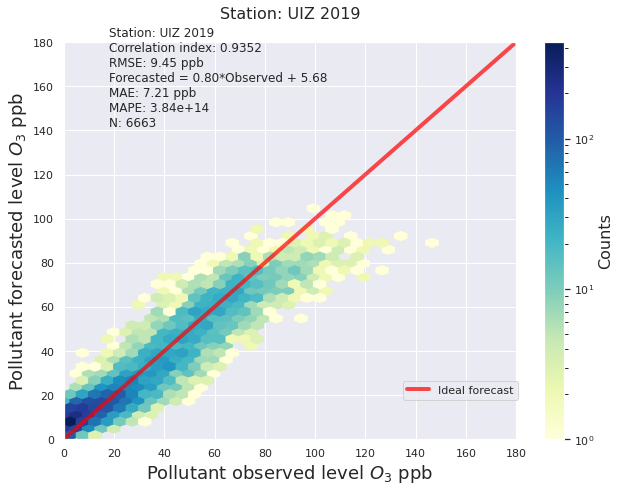

column name:plus_06_cont_otres_UIZ
Correlation index:                     0.8965


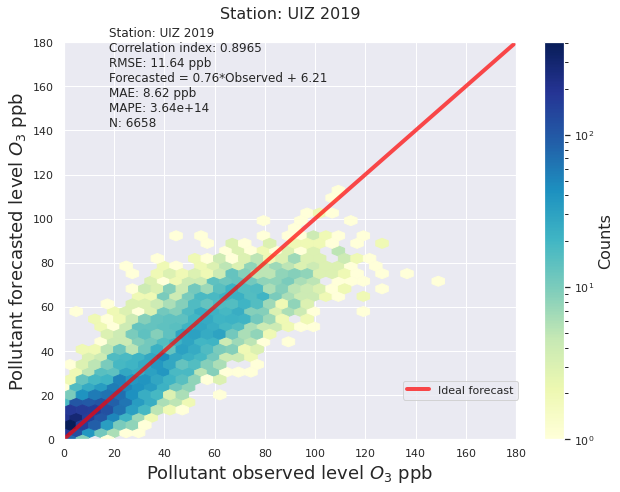

column name:plus_12_cont_otres_UIZ
Correlation index:                     0.8951


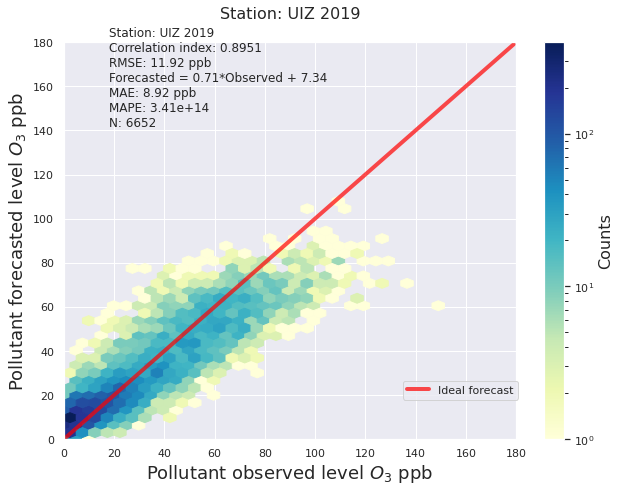

column name:plus_18_cont_otres_UIZ
Correlation index:                     0.8861


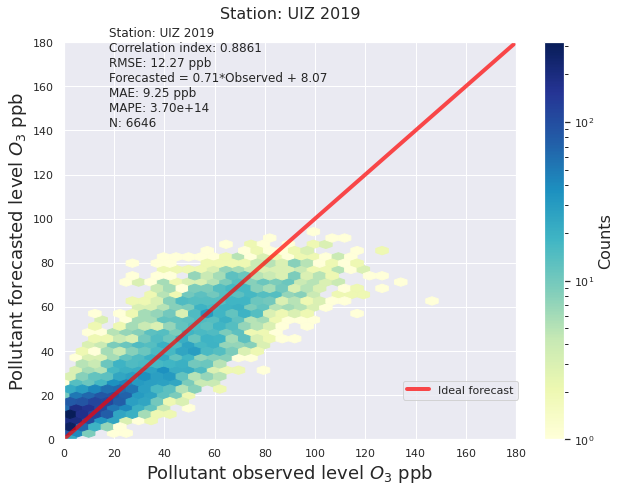

column name:plus_24_cont_otres_UIZ
Correlation index:                     0.8826


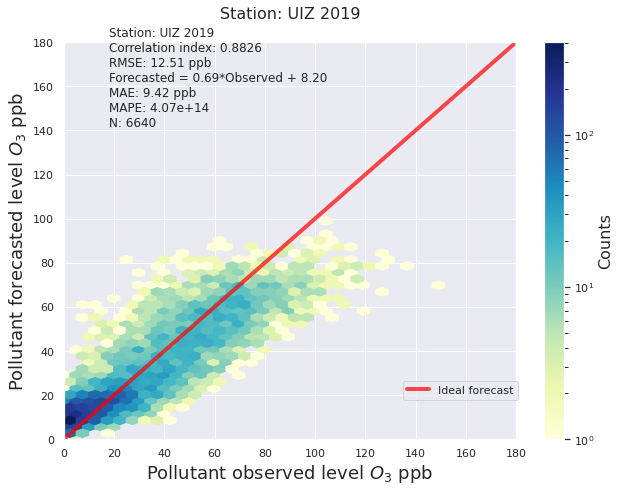

column name:plus_01_cont_otres_AJU
Correlation index:                     0.9026


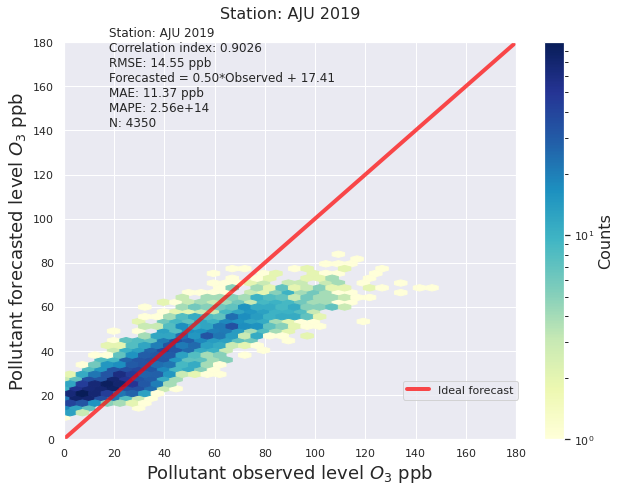

column name:plus_06_cont_otres_AJU
Correlation index:                     0.8626


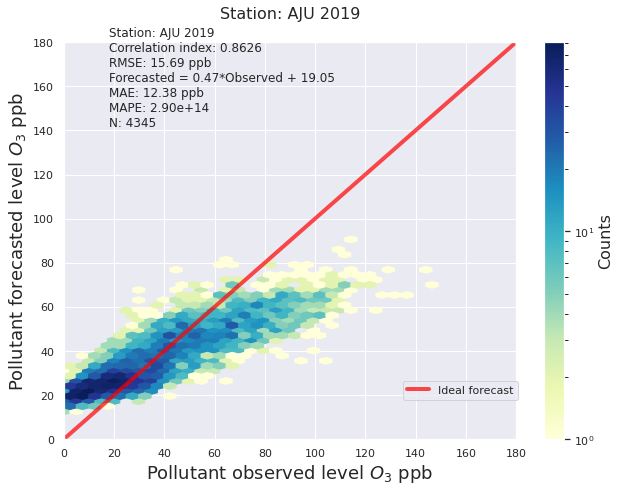

column name:plus_12_cont_otres_AJU
Correlation index:                     0.8661


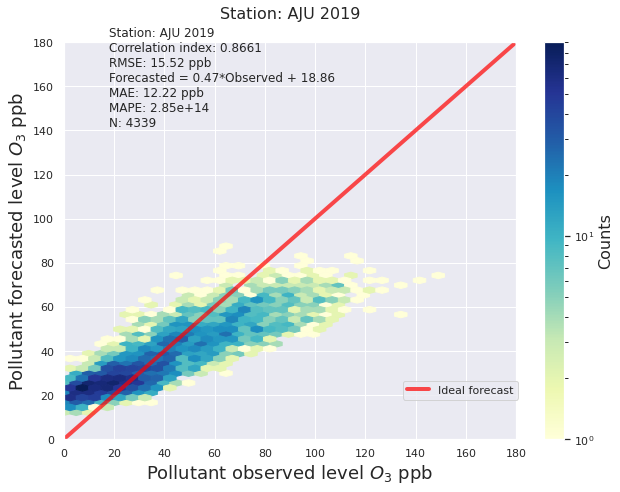

column name:plus_18_cont_otres_AJU
Correlation index:                     0.8581


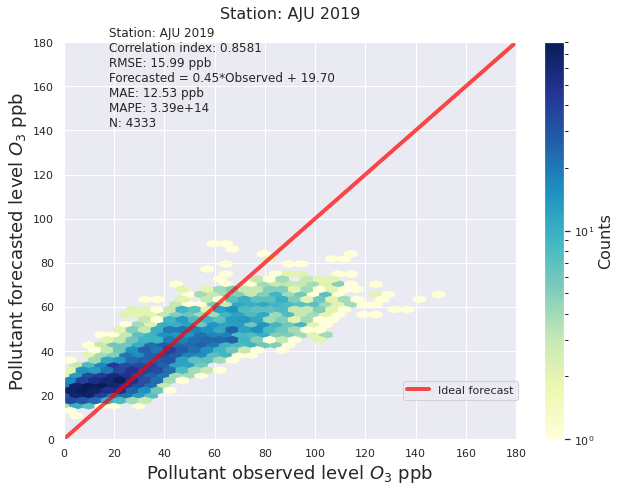

column name:plus_24_cont_otres_AJU
Correlation index:                     0.8520


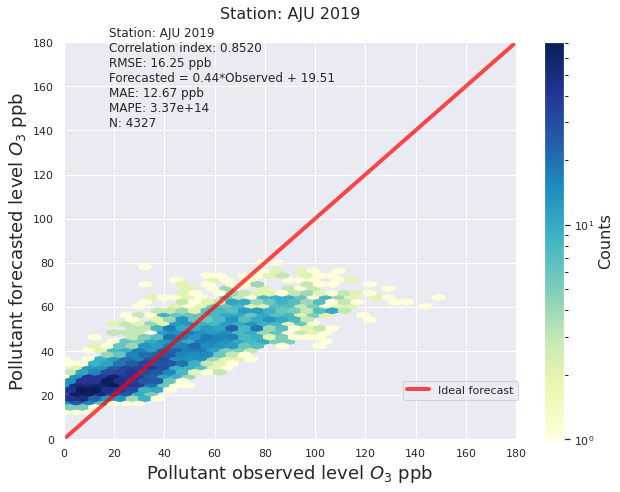

column name:plus_01_cont_otres_ATI
Correlation index:                     0.9268


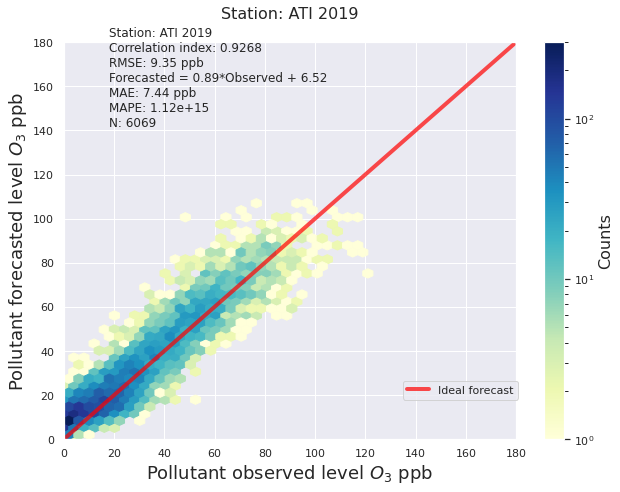

column name:plus_06_cont_otres_ATI
Correlation index:                     0.8846


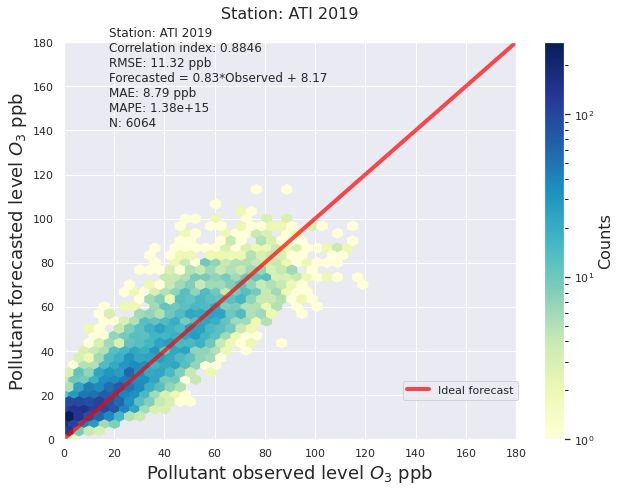

column name:plus_12_cont_otres_ATI
Correlation index:                     0.8793


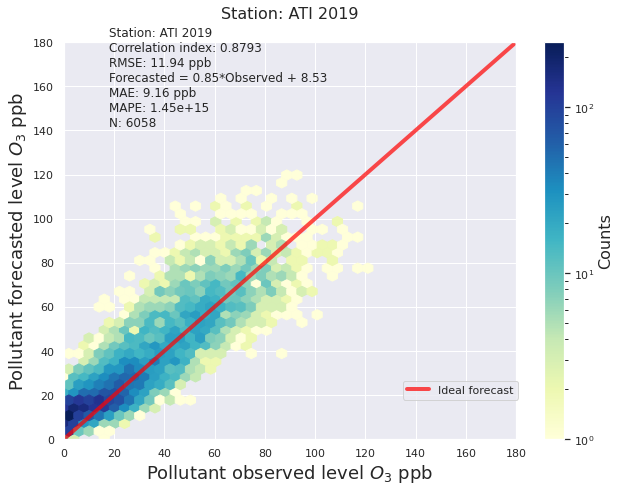

column name:plus_18_cont_otres_ATI
Correlation index:                     0.8877


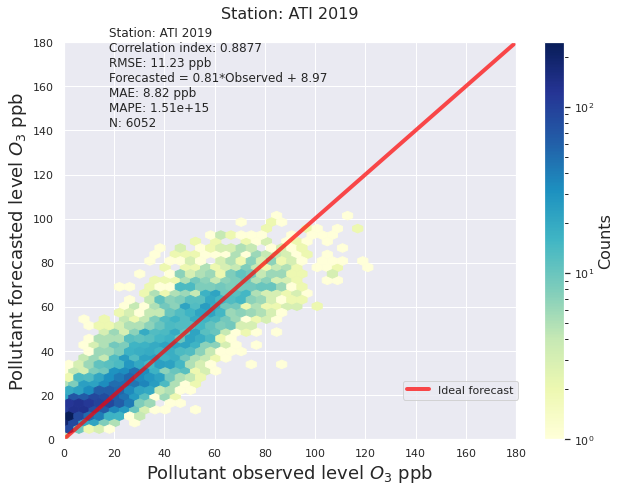

column name:plus_24_cont_otres_ATI
Correlation index:                     0.8764


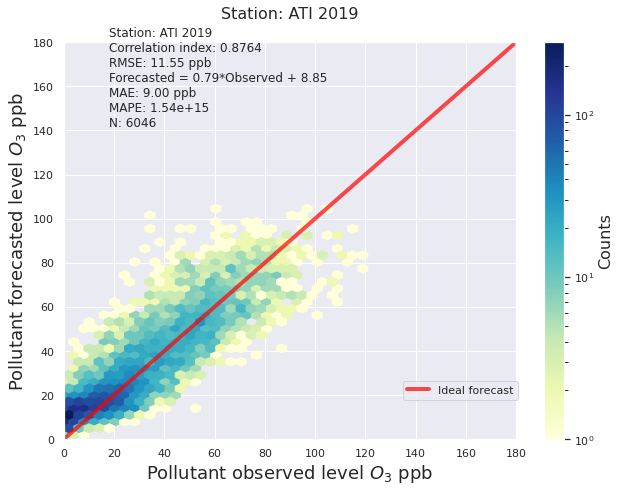

column name:plus_01_cont_otres_UAX
Correlation index:                     0.9086


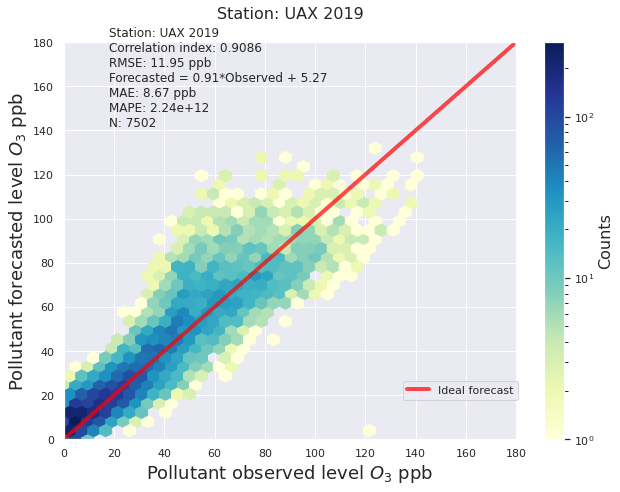

column name:plus_06_cont_otres_UAX
Correlation index:                     0.8786


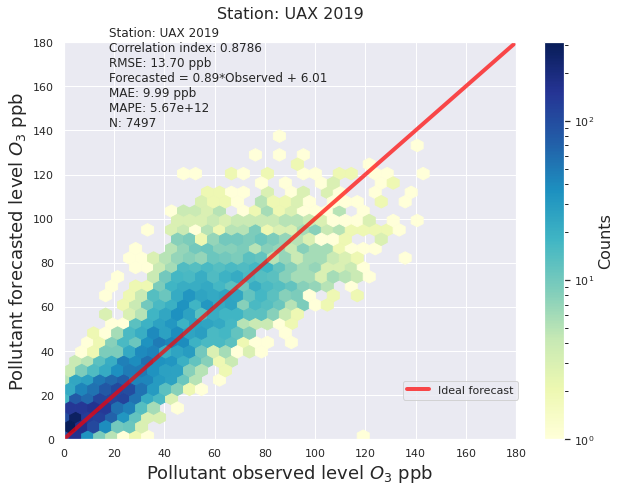

column name:plus_12_cont_otres_UAX
Correlation index:                     0.8693


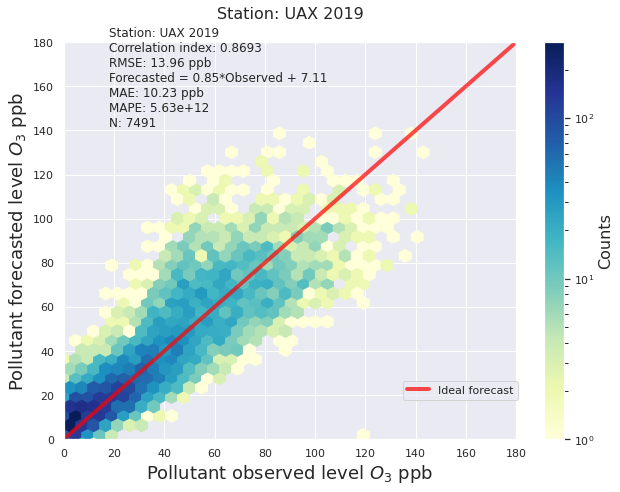

column name:plus_18_cont_otres_UAX
Correlation index:                     0.8734


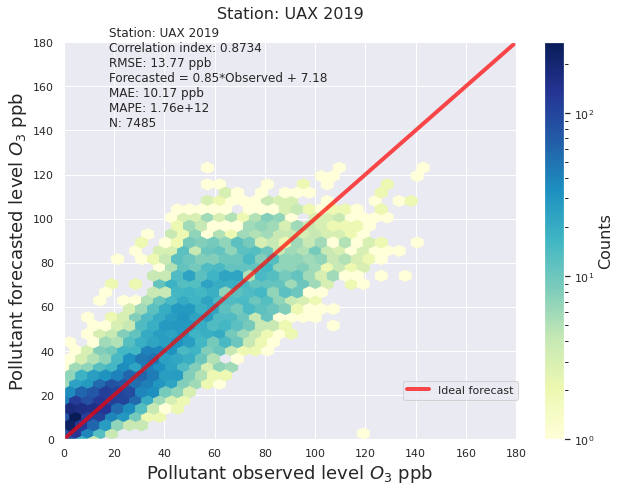

column name:plus_24_cont_otres_UAX
Correlation index:                     0.8563


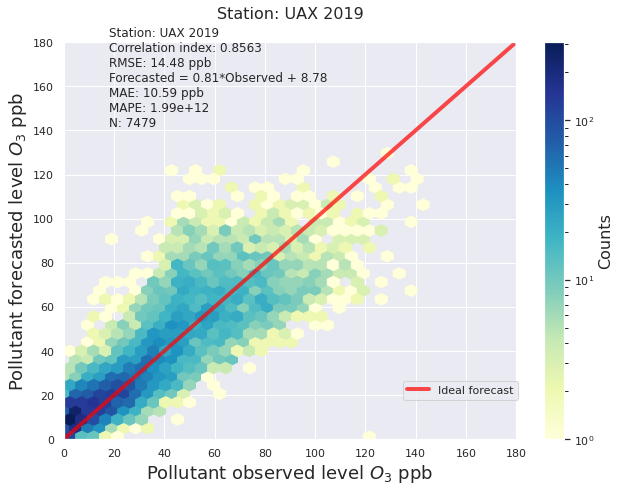

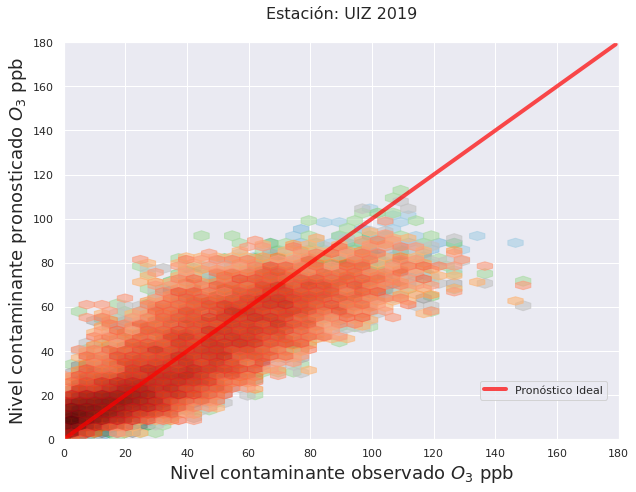

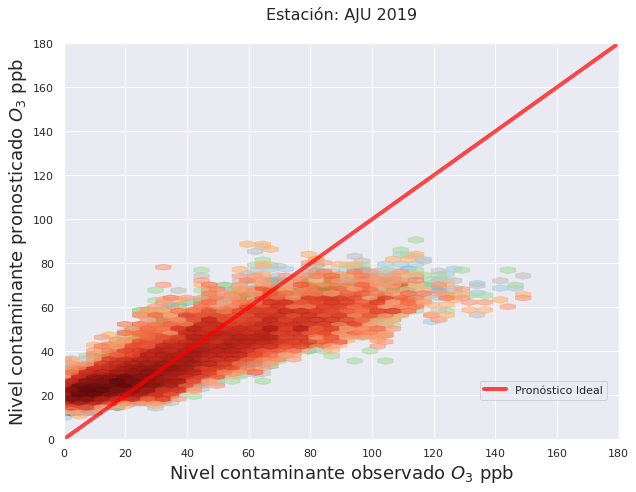

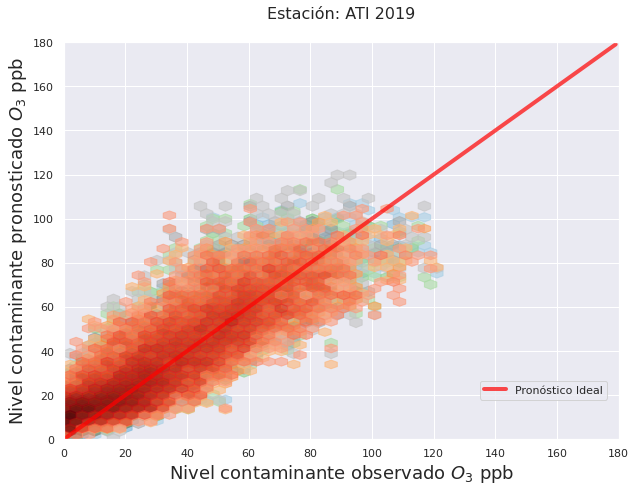

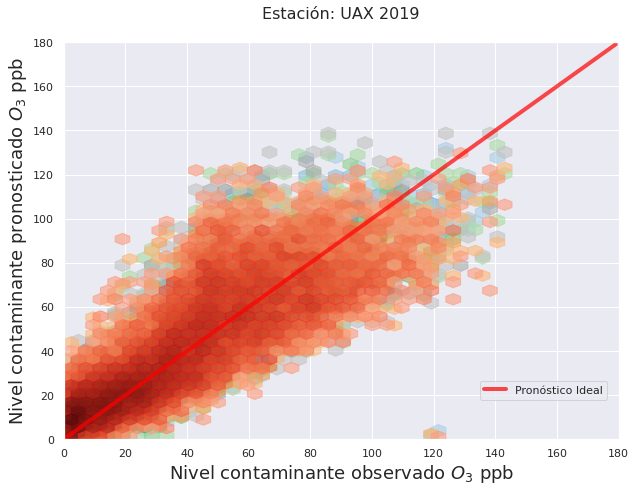

In [34]:
# %% *********** Chooses the proper model and weights ***********

# %% Loading csv with X an Y columns
X_cols_csv = pd.read_csv( join(path_csvs, 'X_columns.csv'))
Y_cols_csv = pd.read_csv( join(path_csvs, 'Y_columns.csv'))

X_cols = X_cols_csv['0'].tolist()
Y_cols = Y_cols_csv['0'].tolist()


# %% ******************* Selecting the model **********************

config[ModelParams.INPUT_SIZE] = INPUT_SIZE
config[ModelParams.NUMBER_OF_OUTPUT_CLASSES] = len(Y_cols)

print('Reading model ....')
model = select_1d_model(config)


# *********** Reads the weights***********
print('Reading weights ....')
model.load_weights(model_weights_file)


# %% Computing predictions of test dataset:
Y_pred = model.predict(X_df.values)

# %% A funciton is defined to generate custom scaler objects
scaler_y = compile_scaler(scaler,Y_cols)


#%% Descale predictions and y_true, and their processing
Y_pred_descaled = scaler_y.inverse_transform(Y_pred)
y_pred_descaled_df = pd.DataFrame(Y_pred_descaled,
                                  columns=scaler_y.feature_names_in_)

print(y_pred_descaled_df.head())

y_true_df = pd.DataFrame(scaler_y.inverse_transform(Y_df),
                         columns=Y_df.columns)
print(y_true_df.head())

# %% Evaluating only a set of stations and hours 
for station in evaluate_stations:
    for hour in evaluate_hours:
        cur_column = f'plus_{hour:02}_cont_otres_{station}'
        print(f'column name:{cur_column}')
        # analyze_column(cur_column)
        analyze_column(cur_column,
                       y_pred_descaled_df,
                       y_true_df,
                       test_year=test_year,
                       output_results_folder_img=output_results_folder_img)

# Plots to evaluate evolution of precisi'on with number of hours ahead as
# red = 24 hours:

for station in evaluate_stations:
    analyze_multi_hour_plot(
        station,
        evaluate_hours,
        y_pred_descaled_df,
        y_true_df,
        test_year=test_year,
        output_results_folder_img=output_results_folder_img)



In [35]:
#Saving results data for further analysis

print(f'output_results_folder: \n\n {output_results_folder}\n')
y_pred_descaled_df.to_csv(f'{output_results_folder}/{string_test}_y_pred_descaled.csv')
y_true_df.to_csv(f'{output_results_folder}/{string_test}_y_true_descaled.csv')

output_results_folder: 

 /ZION/AirPollutionData/Data/Results/TestOZ/TestOZ_otres_2024_01_19_22_05



In [36]:
# %% #Create DataFrame with metric results and save the results in a csv file

results_df = pd.DataFrame(columns=[
    "Columna", "Índice de correlación", "MAE", "MAPE", "MSE", "RMSE", "R2"
])

for cur_column in y_pred_descaled_df.columns:
    print(cur_column)
    column_results = analyze_column(cur_column,
                                    y_pred_descaled_df,
                                    y_true_df,
                                    test_year=test_year,
                                    generate_plot=False)
    results_df = results_df.append(column_results, ignore_index=True)

print(results_df)
results_df.to_csv(join(output_results_folder_data, 'results_df.csv'),
                  index=False)


plus_01_cont_otres_UIZ
Correlation index:                     0.9352
plus_01_cont_otres_AJU
Correlation index:                     0.9026
plus_01_cont_otres_ATI
Correlation index:                     0.9268
plus_01_cont_otres_CUA
Correlation index:                     0.8840
plus_01_cont_otres_SFE
Correlation index:                     0.9006
plus_01_cont_otres_SAG
Correlation index:                     0.9438
plus_01_cont_otres_CUT
Correlation index:                     0.9406
plus_01_cont_otres_PED
Correlation index:                     0.9387
plus_01_cont_otres_TAH
Correlation index:                     0.9201
plus_01_cont_otres_GAM
Correlation index:                     0.9350
plus_01_cont_otres_IZT
Correlation index:                     0.9521
plus_01_cont_otres_CCA
Correlation index:                     0.9407
plus_01_cont_otres_HGM
Correlation index:                     0.9411
plus_01_cont_otres_LPR
Correlation index:                     0.9026
plus_01_cont_otres_MGH
Correlation

plus_06_cont_otres_MGH
Correlation index:                     0.8881
plus_06_cont_otres_CAM
Correlation index:                     0.8944
plus_06_cont_otres_FAC
Correlation index:                     0.8805
plus_06_cont_otres_TLA
Correlation index:                     0.8940
plus_06_cont_otres_MER
Correlation index:                     0.8999
plus_06_cont_otres_XAL
Correlation index:                     0.8896
plus_06_cont_otres_LLA
Correlation index:                     0.8996
plus_06_cont_otres_TLI
Correlation index:                     0.8991
plus_06_cont_otres_UAX
Correlation index:                     0.8786
plus_06_cont_otres_BJU
Correlation index:                     0.8851
plus_06_cont_otres_MPA
Correlation index:                     0.8328
plus_06_cont_otres_MON
Correlation index:                     0.8955
plus_06_cont_otres_NEZ
Correlation index:                     0.8985
plus_06_cont_otres_INN
Correlation index:                     0.8001
plus_06_cont_otres_AJM
Correlation

plus_11_cont_otres_SFE
Correlation index:                     0.8473
plus_11_cont_otres_SAG
Correlation index:                     0.9051
plus_11_cont_otres_CUT
Correlation index:                     0.9104
plus_11_cont_otres_PED
Correlation index:                     0.8884
plus_11_cont_otres_TAH
Correlation index:                     0.8825
plus_11_cont_otres_GAM
Correlation index:                     0.8938
plus_11_cont_otres_IZT
Correlation index:                     0.9046
plus_11_cont_otres_CCA
Correlation index:                     0.8876
plus_11_cont_otres_HGM
Correlation index:                     0.8919
plus_11_cont_otres_LPR
Correlation index:                     0.8700
plus_11_cont_otres_MGH
Correlation index:                     0.8822
plus_11_cont_otres_CAM
Correlation index:                     0.8956
plus_11_cont_otres_FAC
Correlation index:                     0.8709
plus_11_cont_otres_TLA
Correlation index:                     0.8923
plus_11_cont_otres_MER
Correlation

Correlation index:                     0.8962
plus_15_cont_otres_NEZ
Correlation index:                     0.8916
plus_15_cont_otres_INN
Correlation index:                     0.7872
plus_15_cont_otres_AJM
Correlation index:                     0.8238
plus_15_cont_otres_VIF
Correlation index:                     0.8508
plus_16_cont_otres_UIZ
Correlation index:                     0.8922
plus_16_cont_otres_AJU
Correlation index:                     0.8562
plus_16_cont_otres_ATI
Correlation index:                     0.8832
plus_16_cont_otres_CUA
Correlation index:                     0.8124
plus_16_cont_otres_SFE
Correlation index:                     0.8427
plus_16_cont_otres_SAG
Correlation index:                     0.9055
plus_16_cont_otres_CUT
Correlation index:                     0.9026
plus_16_cont_otres_PED
Correlation index:                     0.8860
plus_16_cont_otres_TAH
Correlation index:                     0.8752
plus_16_cont_otres_GAM
Correlation index:                

Correlation index:                     0.8964
plus_20_cont_otres_MER
Correlation index:                     0.8940
plus_20_cont_otres_XAL
Correlation index:                     0.8865
plus_20_cont_otres_LLA
Correlation index:                     0.9008
plus_20_cont_otres_TLI
Correlation index:                     0.9023
plus_20_cont_otres_UAX
Correlation index:                     0.8688
plus_20_cont_otres_BJU
Correlation index:                     0.8824
plus_20_cont_otres_MPA
Correlation index:                     0.8263
plus_20_cont_otres_MON
Correlation index:                     0.8954
plus_20_cont_otres_NEZ
Correlation index:                     0.8901
plus_20_cont_otres_INN
Correlation index:                     0.7888
plus_20_cont_otres_AJM
Correlation index:                     0.8322
plus_20_cont_otres_VIF
Correlation index:                     0.8672
plus_21_cont_otres_UIZ
Correlation index:                     0.8899
plus_21_cont_otres_AJU
Correlation index:                

In [37]:
results_df
# Extract unique station identifiers from the "Columna" column
station_identifiers = results_df['Columna'].str.split('_').str[4].unique()
station_identifiers

array(['UIZ', 'AJU', 'ATI', 'CUA', 'SFE', 'SAG', 'CUT', 'PED', 'TAH',
       'GAM', 'IZT', 'CCA', 'HGM', 'LPR', 'MGH', 'CAM', 'FAC', 'TLA',
       'MER', 'XAL', 'LLA', 'TLI', 'UAX', 'BJU', 'MPA', 'MON', 'NEZ',
       'INN', 'AJM', 'VIF'], dtype=object)

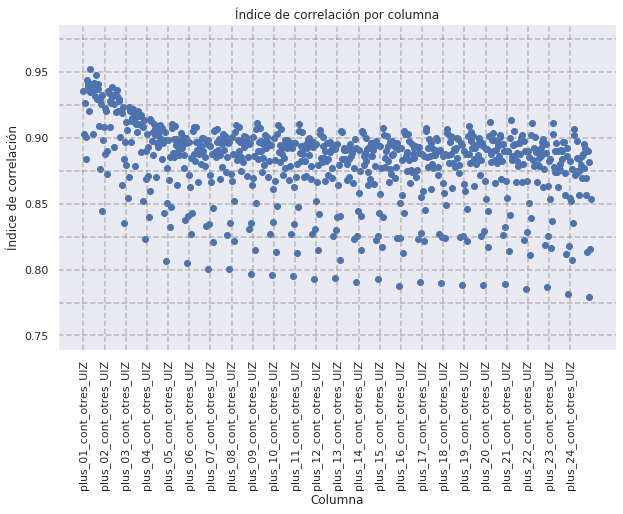

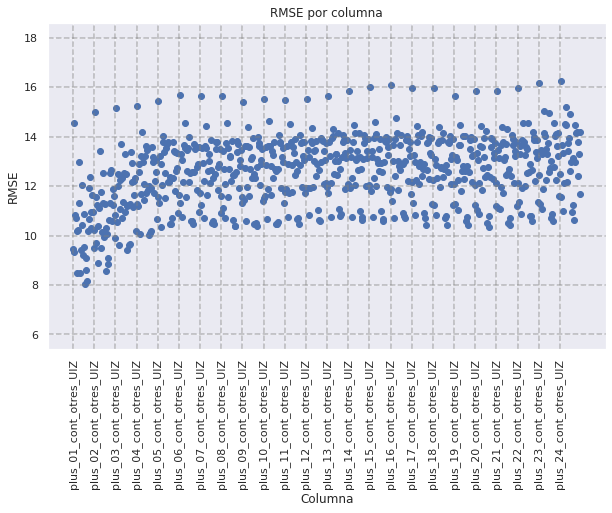

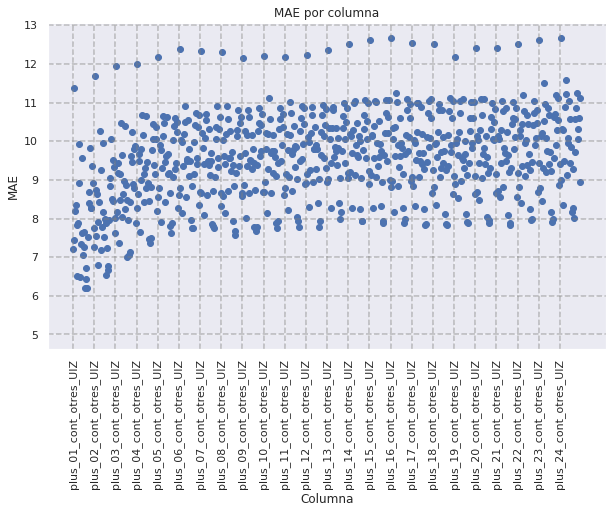

In [38]:
# %% Scatter plot for the given metrics

scatter_plot_by_column(results_df, 'Índice de correlación',
                output_results_folder_img)
scatter_plot_by_column(results_df, 'RMSE', output_results_folder_img)
scatter_plot_by_column(results_df, 'MAE', output_results_folder_img)


Promedio general de Índice de correlación sobre todas las estaciones: 0.8810


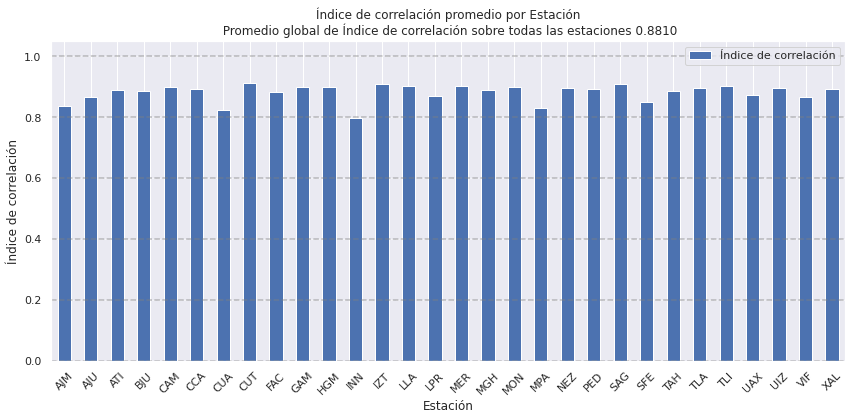

Promedio general de RMSE sobre todas las estaciones: 12.5558


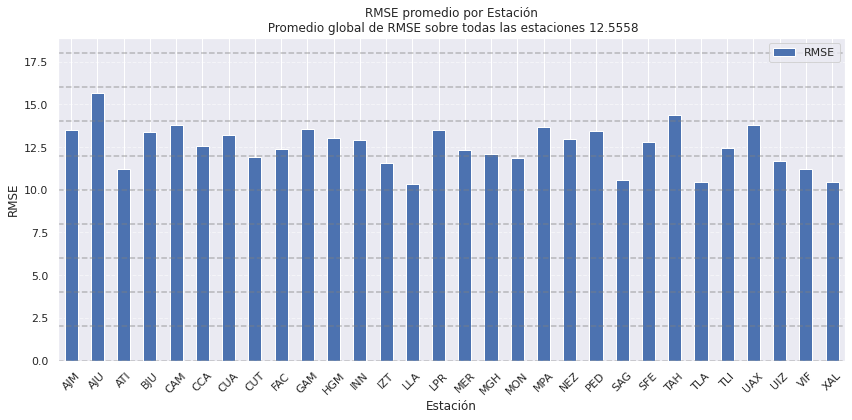

Promedio general de MAE sobre todas las estaciones: 9.5449


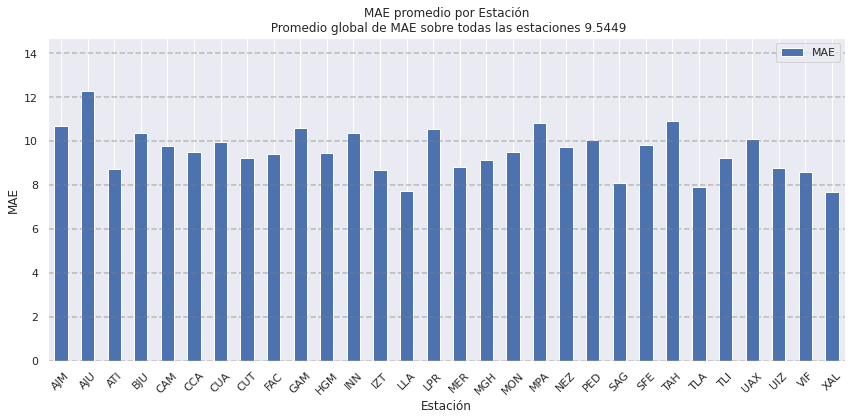

In [39]:
# %% Llamada a función para graficar las métricas de resumen de todas horas por estacion

average_metric(results_df, 'Índice de correlación', output_results_folder_img)
average_metric(results_df, 'RMSE', output_results_folder_img)
average_metric(results_df, 'MAE', output_results_folder_img)

Promedio general de Índice de correlación sobre todas las horas: 0.8810


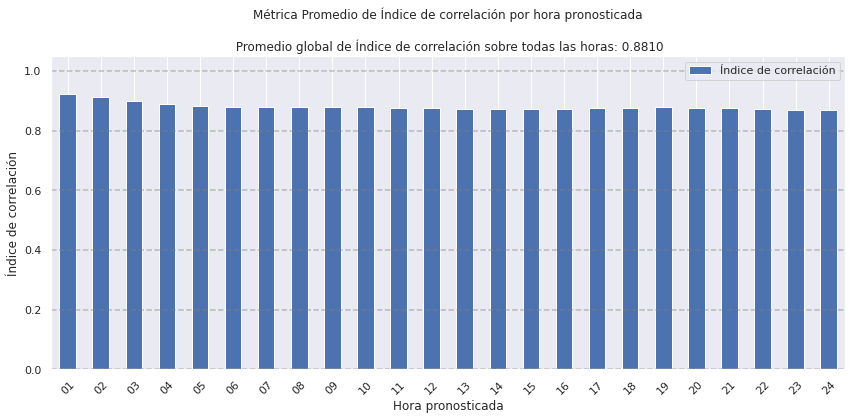

Promedio general de RMSE sobre todas las horas: 12.5558


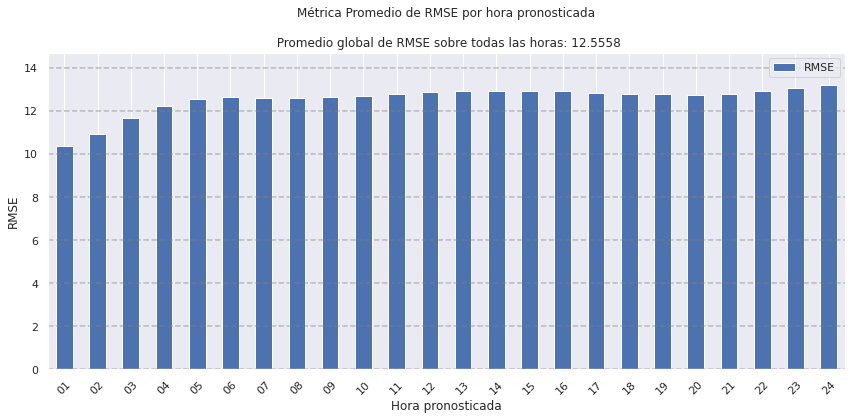

Promedio general de MAE sobre todas las horas: 9.5449


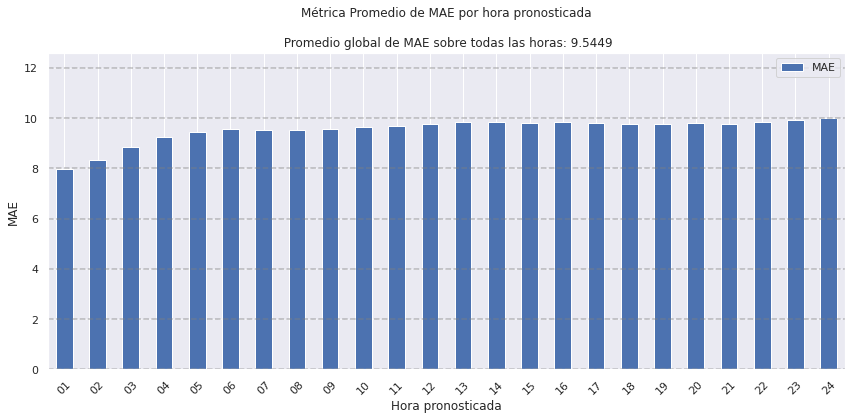

In [40]:
# %% Llamada a función para graficar las métricas de resumen de todas las estaciones por hora
average_metric_by_hour(results_df, 'Índice de correlación', output_results_folder_img)
average_metric_by_hour(results_df, 'RMSE', output_results_folder_img)
average_metric_by_hour(results_df, 'MAE', output_results_folder_img)

In [41]:
# %% 
params_grid = [(f'plus_{hour:02}_cont_{cur_pollutant}_{cur_station}')
               for cur_station in evaluate_stations for hour in evaluate_hours]


plus_01_cont_otres_UIZ


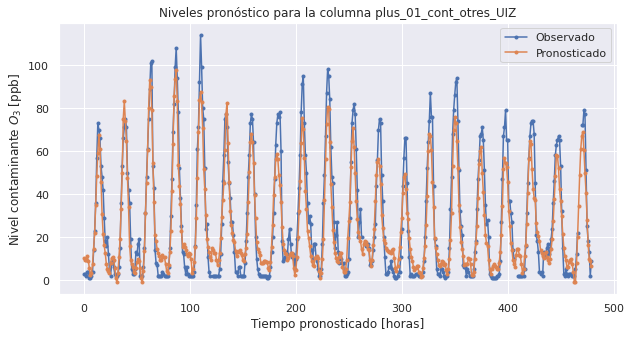

plus_06_cont_otres_UIZ


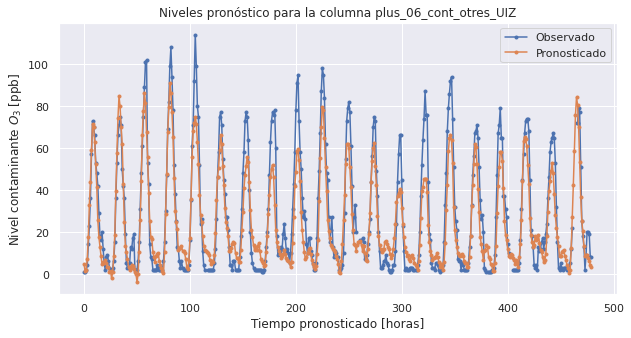

plus_12_cont_otres_UIZ


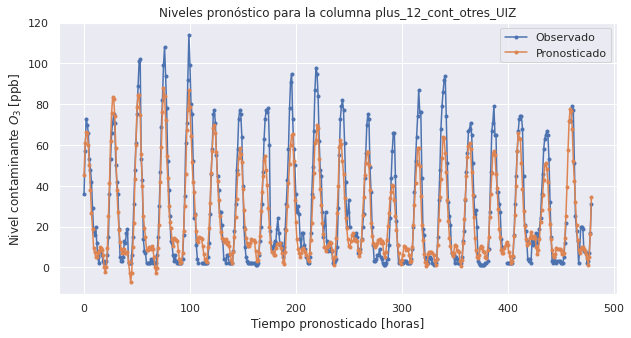

plus_18_cont_otres_UIZ


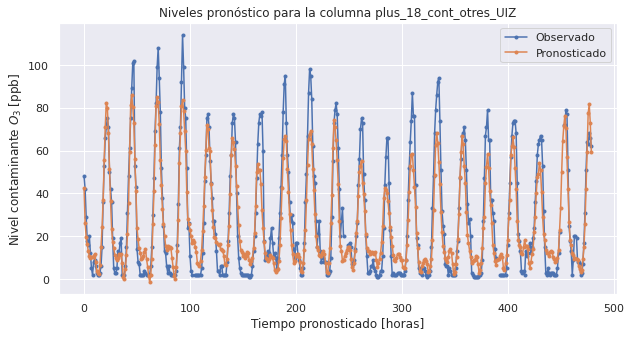

plus_24_cont_otres_UIZ


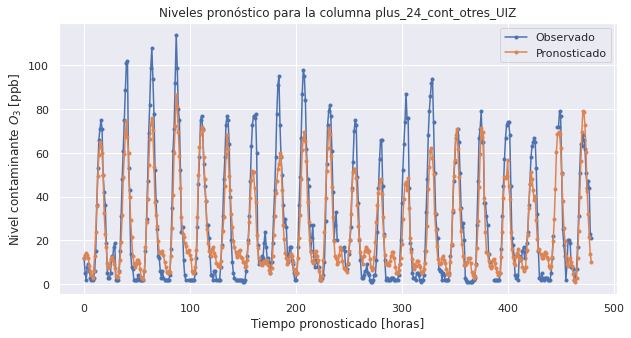

plus_01_cont_otres_AJU


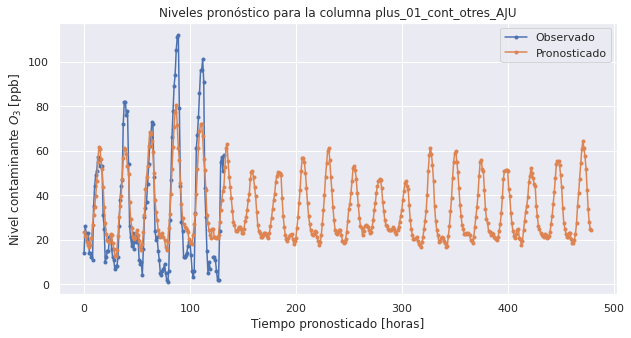

plus_06_cont_otres_AJU


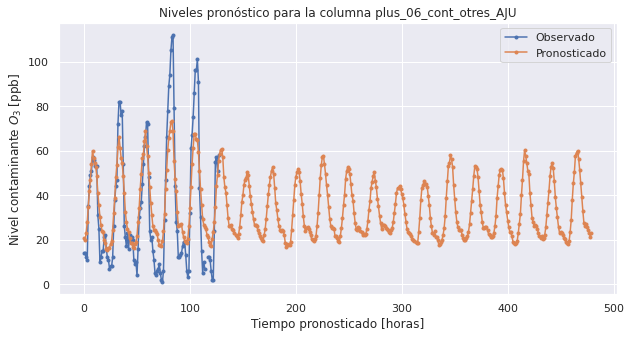

plus_12_cont_otres_AJU


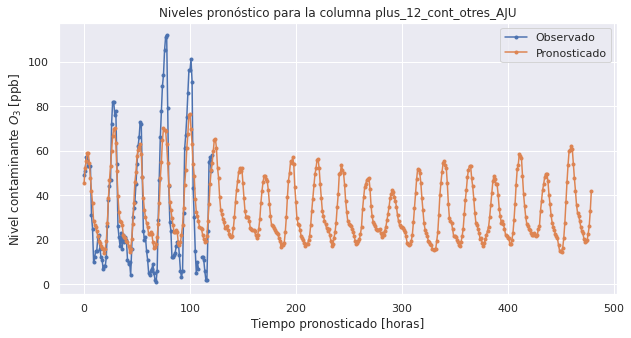

plus_18_cont_otres_AJU


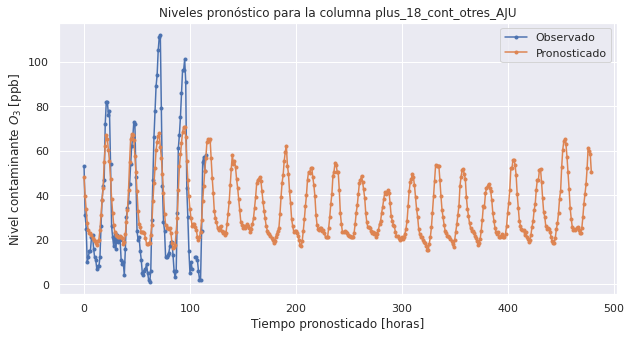

plus_24_cont_otres_AJU


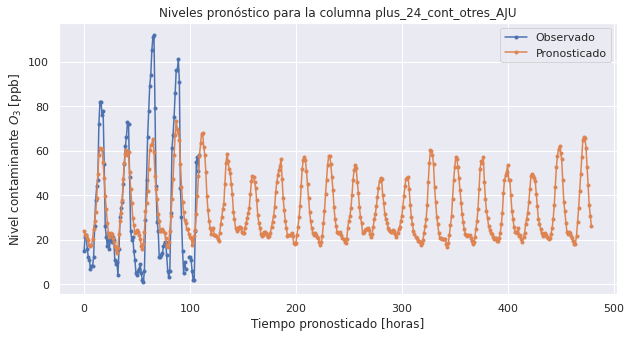

plus_01_cont_otres_ATI


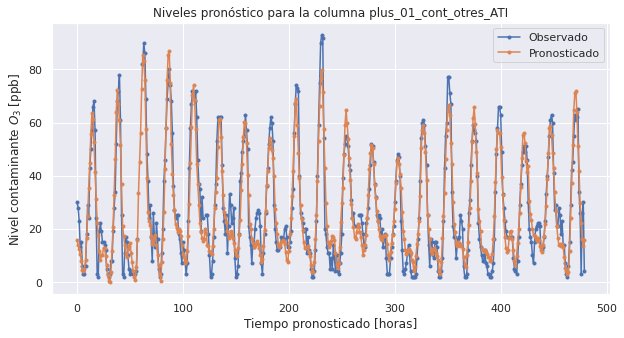

plus_06_cont_otres_ATI


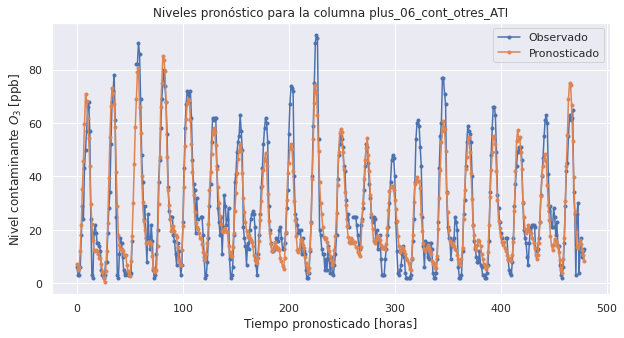

plus_12_cont_otres_ATI


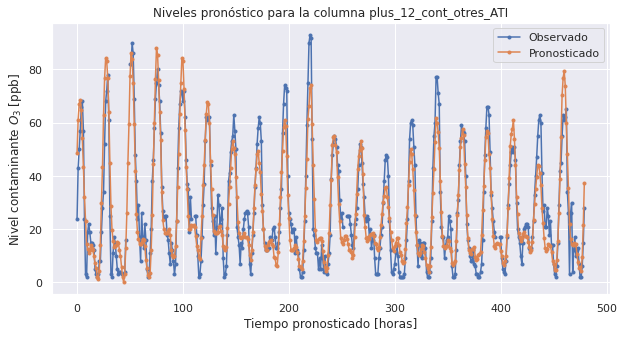

plus_18_cont_otres_ATI


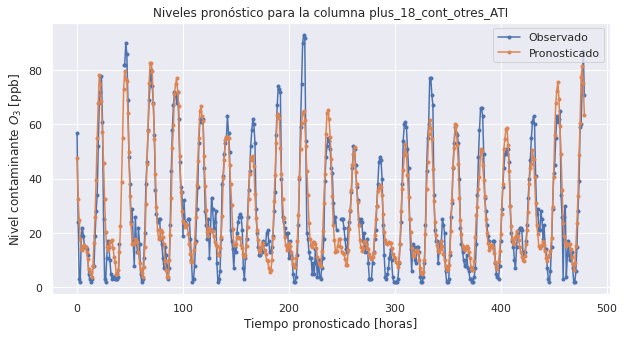

plus_24_cont_otres_ATI


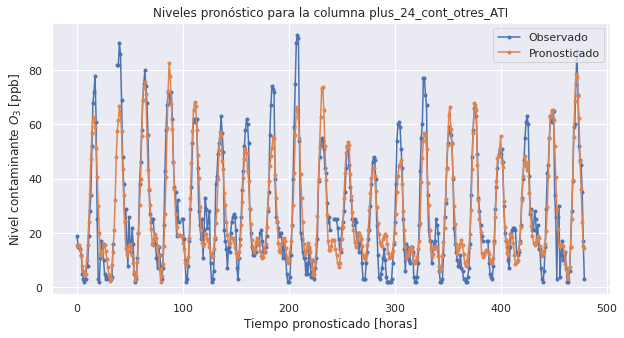

plus_01_cont_otres_UAX


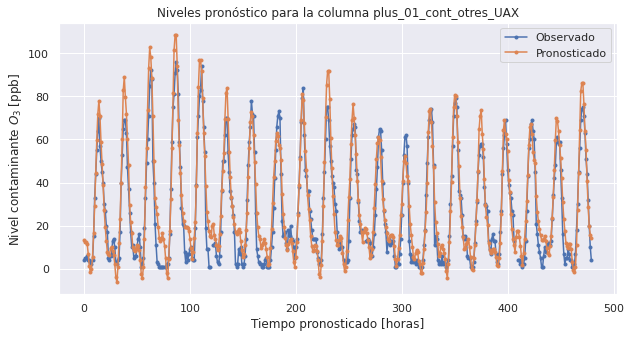

plus_06_cont_otres_UAX


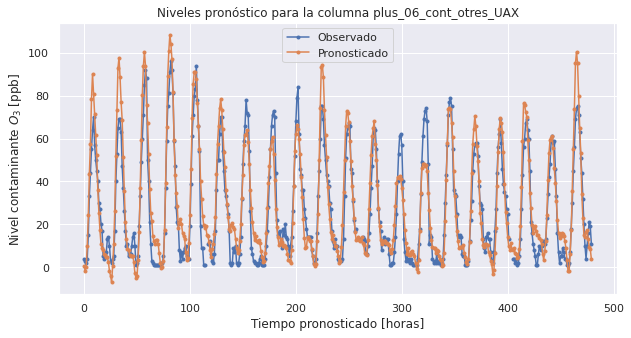

plus_12_cont_otres_UAX


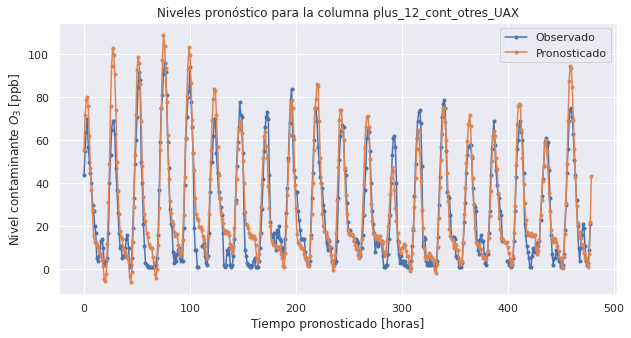

plus_18_cont_otres_UAX


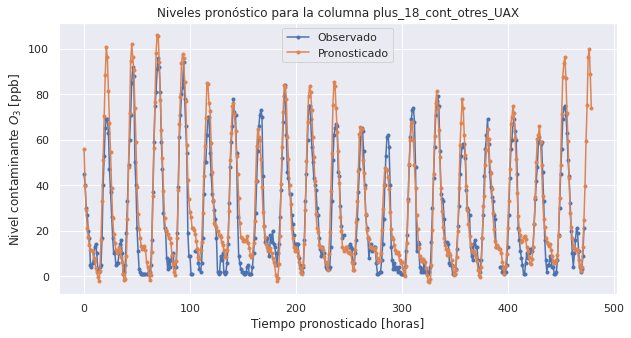

plus_24_cont_otres_UAX


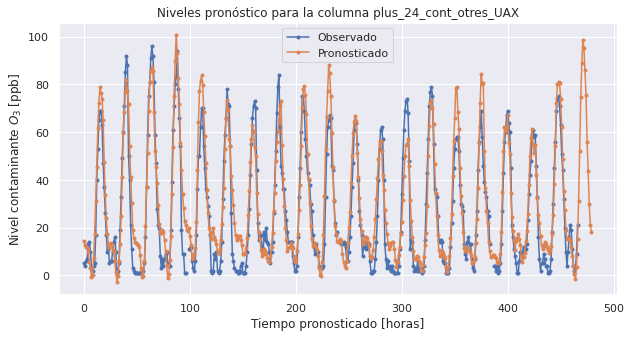

In [42]:
# %% #Hacer gráficas de horas de algunos casos
for cur_column in params_grid:
    print(cur_column)
    # Llamar a la función con la columna deseada
    plot_forecast_hours(cur_column, y_true_df,
                        y_pred_descaled_df)  # , path_home)

plus_01_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 3.593998202631029
Desviación estándar de diferencia en valores máximos diarios: 13.371078024403479


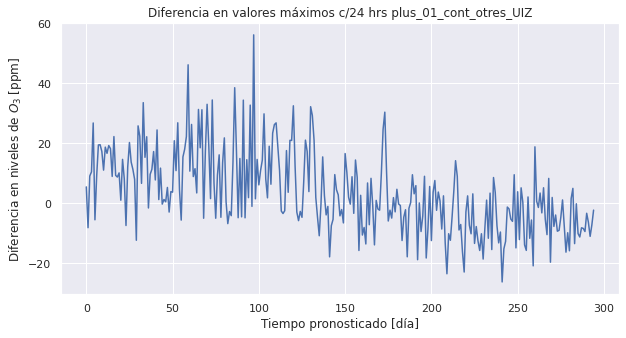

plus_06_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 5.904121043318409
Desviación estándar de diferencia en valores máximos diarios: 16.669925103397485


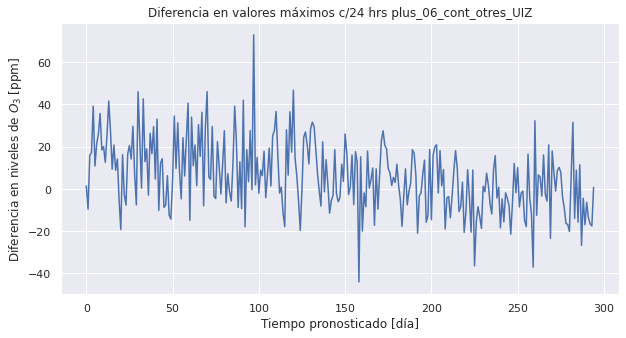

plus_12_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 8.696413352736661
Desviación estándar de diferencia en valores máximos diarios: 16.033057851766312


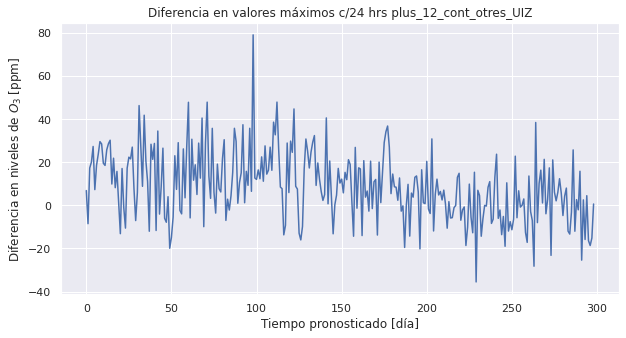

plus_18_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 6.684927379762804
Desviación estándar de diferencia en valores máximos diarios: 17.200116285321954


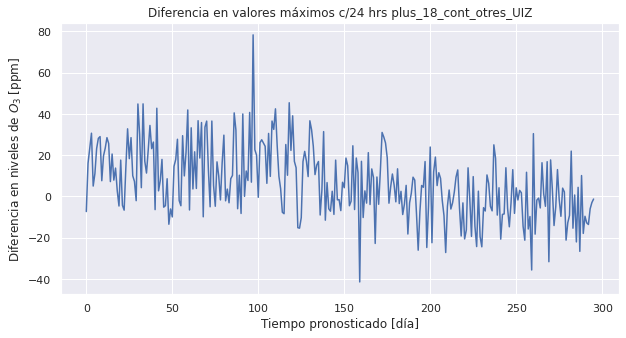

plus_24_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 7.606744085039411
Desviación estándar de diferencia en valores máximos diarios: 17.4722801643362


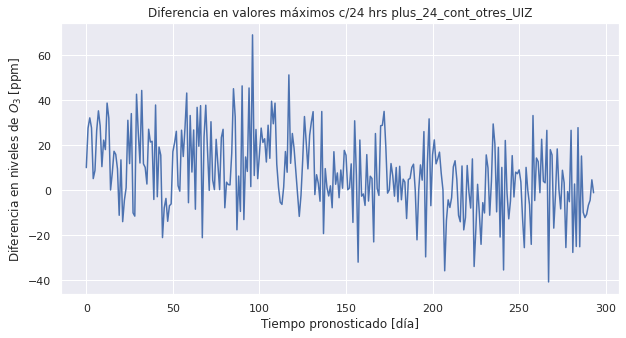

plus_01_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 17.65379271356229
Desviación estándar de diferencia en valores máximos diarios: 18.218609421874678


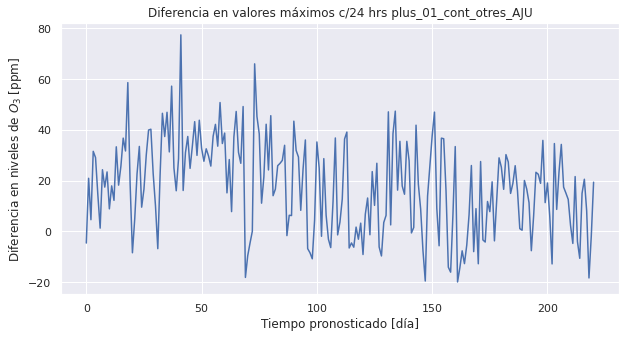

plus_06_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 16.874486124193346
Desviación estándar de diferencia en valores máximos diarios: 19.658376152917118


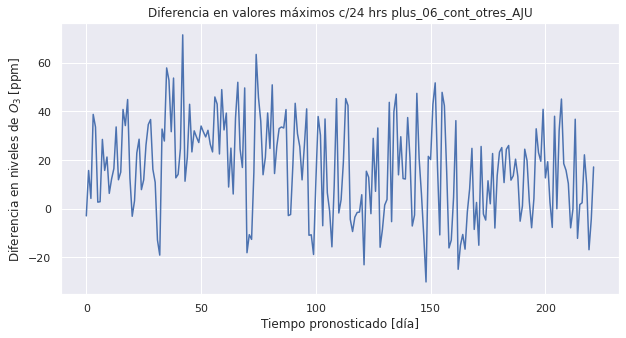

plus_12_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 17.81337341102394
Desviación estándar de diferencia en valores máximos diarios: 18.419927413902073


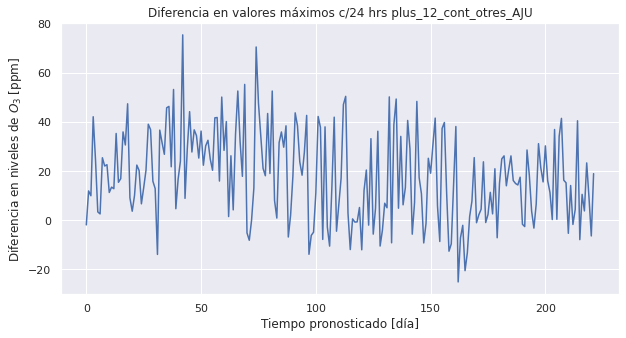

plus_18_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 19.156721445719402
Desviación estándar de diferencia en valores máximos diarios: 19.779055923360414


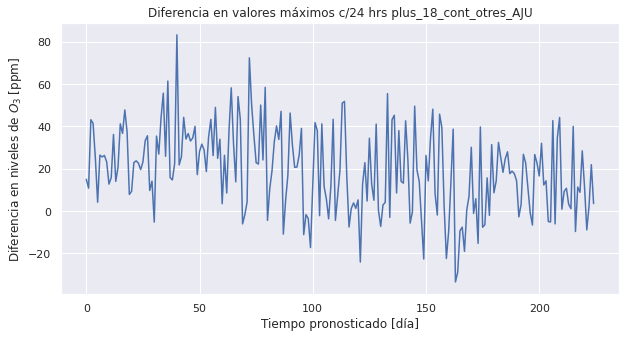

plus_24_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 19.09249467719091
Desviación estándar de diferencia en valores máximos diarios: 20.719877577137343


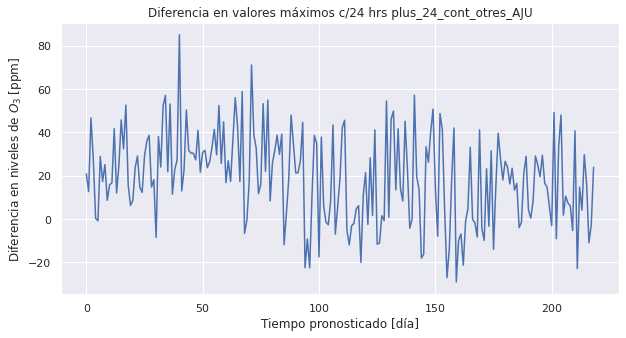

plus_01_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: -2.9574971993764243
Desviación estándar de diferencia en valores máximos diarios: 11.057166211707866


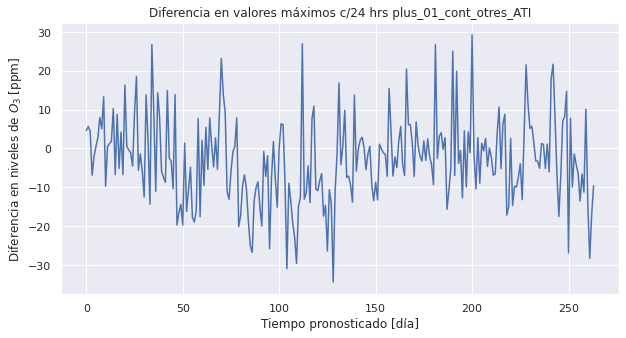

plus_06_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: -1.6067128432424445
Desviación estándar de diferencia en valores máximos diarios: 15.031765865970245


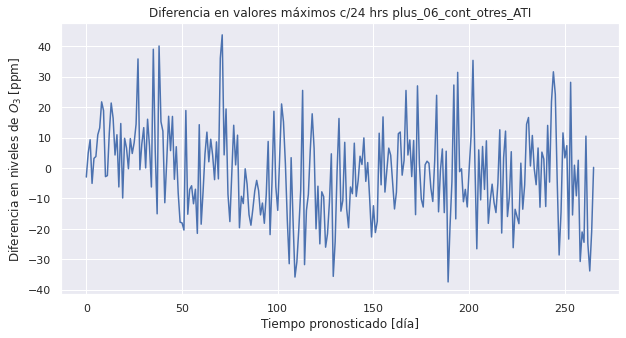

plus_12_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: -2.8382642717289746
Desviación estándar de diferencia en valores máximos diarios: 15.821697490494428


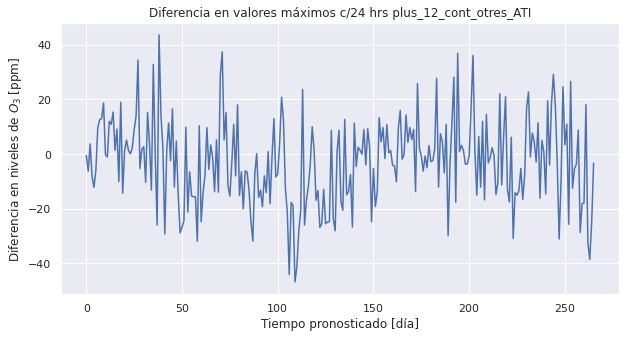

plus_18_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: -0.2663134808810252
Desviación estándar de diferencia en valores máximos diarios: 13.966872592755049


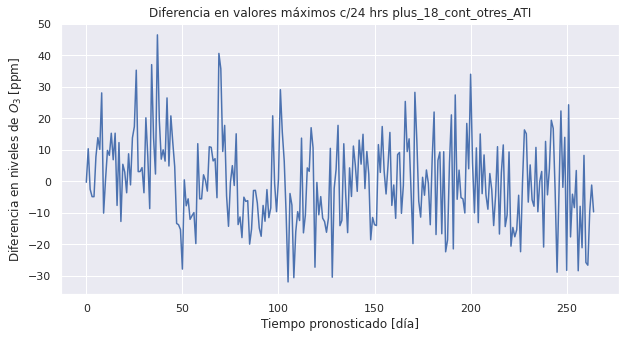

plus_24_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: -0.29886740558552294
Desviación estándar de diferencia en valores máximos diarios: 15.68868863441711


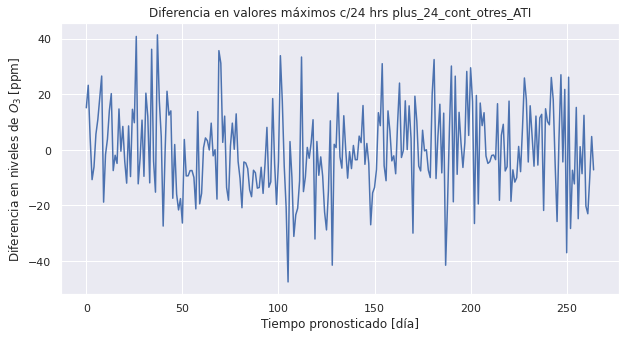

plus_01_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: -1.415676787092879
Desviación estándar de diferencia en valores máximos diarios: 19.347679489545907


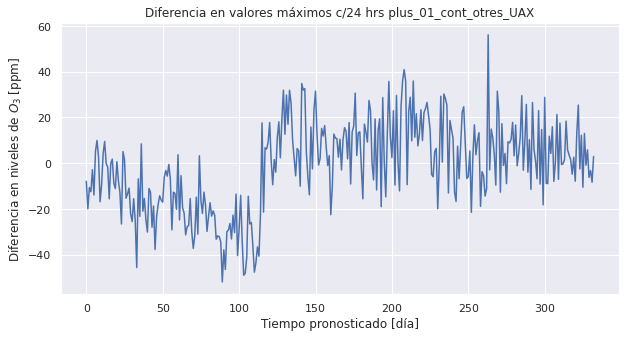

plus_06_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: -2.001538396595481
Desviación estándar de diferencia en valores máximos diarios: 21.93298006018087


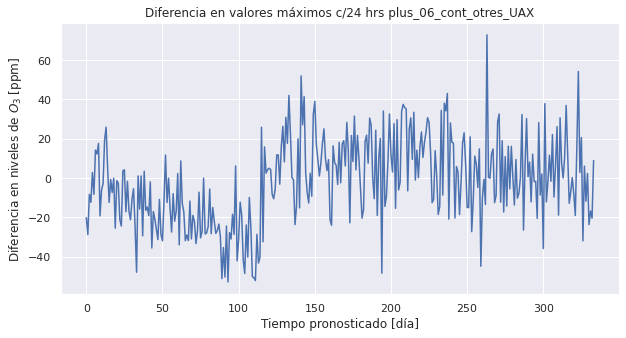

plus_12_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: -0.04883491425287156
Desviación estándar de diferencia en valores máximos diarios: 21.868285403612884


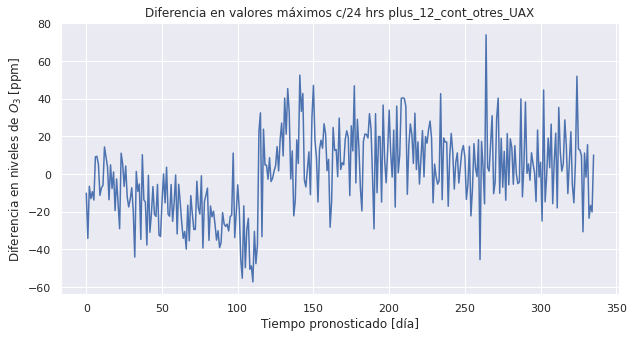

plus_18_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: -1.017153286072145
Desviación estándar de diferencia en valores máximos diarios: 21.675603864345863


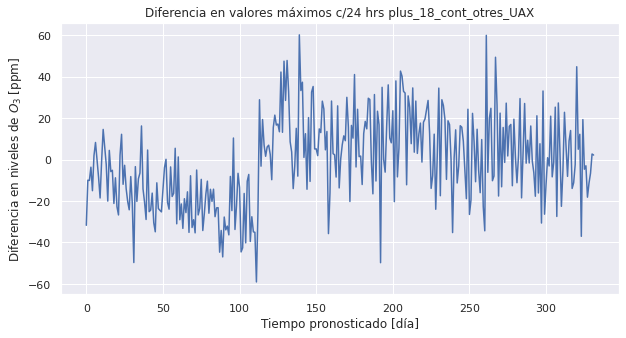

plus_24_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: 1.0781207343962977
Desviación estándar de diferencia en valores máximos diarios: 23.613873390504263


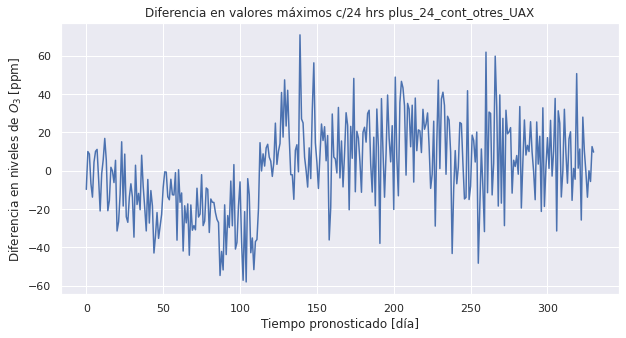

Promedio de h24_max_err_mean: 5.585216729237337
Promedio de h24_max_err_std: 17.877345846097572


In [43]:
# %% Calculo de valores máximos por cada 24 horas. 
# Crear un DataFrame vacío

results_max_df = pd.DataFrame(columns=[
    'max_y_true', 'max_y_pred', 'h24_max_err_mean', 'h24_max_err_std'
])

# Rellenar el DataFrame con los resultados de la función
for cur_column in params_grid:
    print(cur_column)
    max_y_true, max_y_pred, h24_max_err_mean, h24_max_err_std = plot_max_difference(
        cur_column, y_true_df, y_pred_descaled_df)
    results_max_df = results_max_df.append(
        {
            'max_y_true': max_y_true,
            'max_y_pred': max_y_pred,
            'h24_max_err_mean': h24_max_err_mean,
            'h24_max_err_std': h24_max_err_std
        },
        ignore_index=True)

# Calcular el promedio de las cuatro columnas
average_h24_max_err_mean = results_max_df['h24_max_err_mean'].mean()
average_h24_max_err_std = results_max_df['h24_max_err_std'].mean()

print("Promedio de h24_max_err_mean:", average_h24_max_err_mean)
print("Promedio de h24_max_err_std:", average_h24_max_err_std)


In [44]:
# Inicializar nuevas columnas para almacenar los resultados adicionales
results_df['h24_max_err_mean'] = 0.0
results_df['h24_max_err_std'] = 0.0
results_df['h24_mean_err_mean'] = 0.0
results_df['h24_mean_err_std'] = 0.0
errors_dict = {}

# Iterar a través de cada fila en el DataFrame para actualizar las nuevas columnas
for index, row in results_df.iterrows():
    cur_column = row['Columna']
    # Llamar a la función plot_max_and_mean_difference y obtener los resultados
    max_y_true, max_y_pred, h24_max_err_mean, h24_max_err_std, mean_y_true, mean_y_pred, h24_mean_err_mean, h24_mean_err_std = plot_max_and_mean_difference(cur_column, y_true_df, y_pred_descaled_df)
    
    # Actualizar las nuevas columnas con los resultados obtenidos
    results_df.loc[index, 'h24_max_err_mean'] = h24_max_err_mean
    results_df.loc[index, 'h24_max_err_std'] = h24_max_err_std
    results_df.loc[index, 'h24_mean_err_mean'] = h24_mean_err_mean
    results_df.loc[index, 'h24_mean_err_std'] = h24_mean_err_std
    # Almacenar max_y_true, max_y_pred, mean_y_true, y mean_y_pred en el diccionario errors_dict
    errors_dict[cur_column] = {
        'max_y_true': max_y_true,
        'max_y_pred': max_y_pred,
        'mean_y_true': mean_y_true,
        'mean_y_pred': mean_y_pred
    }
# Ahora, results_df debería tener las nuevas columnas llenas con los resultados de la función

plus_01_cont_otres_UIZ
Maximum error mean over 24 hrs: 3.593998202631029
Maximum error std dev over 24 hrs: 13.371078024403479
Mean error mean over 24 hrs: 0.015692936313354555
Mean error std dev over 24 hrs: 4.6245912960817535
plus_01_cont_otres_AJU
Maximum error mean over 24 hrs: 17.65379271356229
Maximum error std dev over 24 hrs: 18.218609421874678
Mean error mean over 24 hrs: 1.0340301220952839
Mean error std dev over 24 hrs: 5.810974184588909
plus_01_cont_otres_ATI
Maximum error mean over 24 hrs: -2.9574971993764243
Maximum error std dev over 24 hrs: 11.057166211707866
Mean error mean over 24 hrs: -3.3162168396843805
Mean error std dev over 24 hrs: 3.555198887013912
plus_01_cont_otres_CUA
Maximum error mean over 24 hrs: -0.4741168887883167
Maximum error std dev over 24 hrs: 16.636617999209722
Mean error mean over 24 hrs: 0.516602969421548
Mean error std dev over 24 hrs: 5.160633248028043
plus_01_cont_otres_SFE
Maximum error mean over 24 hrs: -0.5809225785104852
Maximum error std 

plus_05_cont_otres_UIZ
Maximum error mean over 24 hrs: 4.665896357520152
Maximum error std dev over 24 hrs: 16.162660221126064
Mean error mean over 24 hrs: 0.5965288142026481
Mean error std dev over 24 hrs: 5.241835522729656
plus_05_cont_otres_AJU
Maximum error mean over 24 hrs: 17.35813973715942
Maximum error std dev over 24 hrs: 19.021727880027186
Mean error mean over 24 hrs: 0.7448545983833781
Mean error std dev over 24 hrs: 6.549287791987579
plus_05_cont_otres_ATI
Maximum error mean over 24 hrs: -2.2044482482107064
Maximum error std dev over 24 hrs: 14.752304553692467
Mean error mean over 24 hrs: -3.16324275896364
Mean error std dev over 24 hrs: 4.277512057214153
plus_05_cont_otres_CUA
Maximum error mean over 24 hrs: -0.9838777684617317
Maximum error std dev over 24 hrs: 20.081338279485234
Mean error mean over 24 hrs: 1.4290943254798765
Mean error std dev over 24 hrs: 5.656281511880591
plus_05_cont_otres_SFE
Maximum error mean over 24 hrs: -1.6929727281842912
Maximum error std dev 

plus_08_cont_otres_PED
Maximum error mean over 24 hrs: 6.558051911897437
Maximum error std dev over 24 hrs: 19.52108701946477
Mean error mean over 24 hrs: 2.2439622720198114
Mean error std dev over 24 hrs: 5.863605415707119
plus_08_cont_otres_TAH
Maximum error mean over 24 hrs: 18.617740973448143
Maximum error std dev over 24 hrs: 18.444313561543705
Mean error mean over 24 hrs: 2.620490922321055
Mean error std dev over 24 hrs: 6.041046862777103
plus_08_cont_otres_GAM
Maximum error mean over 24 hrs: 10.876989422505991
Maximum error std dev over 24 hrs: 17.900027291763703
Mean error mean over 24 hrs: -0.37715114208085465
Mean error std dev over 24 hrs: 6.048177557082414
plus_08_cont_otres_IZT
Maximum error mean over 24 hrs: 5.644804943752828
Maximum error std dev over 24 hrs: 16.20892807335773
Mean error mean over 24 hrs: -0.29611852142096895
Mean error std dev over 24 hrs: 4.95073219095933
plus_08_cont_otres_CCA
Maximum error mean over 24 hrs: 4.208714149367641
Maximum error std dev ove

Maximum error std dev over 24 hrs: 15.187830336584305
Mean error mean over 24 hrs: -0.6043915215792229
Mean error std dev over 24 hrs: 5.240643710505647
plus_11_cont_otres_PED
Maximum error mean over 24 hrs: 4.407776088991027
Maximum error std dev over 24 hrs: 18.889818600352083
Mean error mean over 24 hrs: 1.8257922484678921
Mean error std dev over 24 hrs: 5.986380415287694
plus_11_cont_otres_TAH
Maximum error mean over 24 hrs: 17.40587083746286
Maximum error std dev over 24 hrs: 17.644140221362647
Mean error mean over 24 hrs: 2.4945733335583244
Mean error std dev over 24 hrs: 6.013938419021143
plus_11_cont_otres_GAM
Maximum error mean over 24 hrs: 10.201452150812067
Maximum error std dev over 24 hrs: 17.54851243383233
Mean error mean over 24 hrs: -0.15195141218810201
Mean error std dev over 24 hrs: 6.197734683305266
plus_11_cont_otres_IZT
Maximum error mean over 24 hrs: 2.872847127242827
Maximum error std dev over 24 hrs: 15.55372875598589
Mean error mean over 24 hrs: -0.011504780014

plus_13_cont_otres_INN
Maximum error mean over 24 hrs: 9.152333426308799
Maximum error std dev over 24 hrs: 17.169516681431723
Mean error mean over 24 hrs: -1.5386972938662087
Mean error std dev over 24 hrs: 6.8627647194580215
plus_13_cont_otres_AJM
Maximum error mean over 24 hrs: 2.5766928392298083
Maximum error std dev over 24 hrs: 16.32376125114031
Mean error mean over 24 hrs: -3.4943685517591594
Mean error std dev over 24 hrs: 6.945612726075333
plus_13_cont_otres_VIF
Maximum error mean over 24 hrs: 11.895716213044667
Maximum error std dev over 24 hrs: 16.145422067059513
Mean error mean over 24 hrs: 0.7195175350421951
Mean error std dev over 24 hrs: 5.933316364774211
plus_14_cont_otres_UIZ
Maximum error mean over 24 hrs: 9.258235777784513
Maximum error std dev over 24 hrs: 15.922020235064862
Mean error mean over 24 hrs: 0.5492257118491782
Mean error std dev over 24 hrs: 6.169429740674355
plus_14_cont_otres_AJU
Maximum error mean over 24 hrs: 21.303746650661278
Maximum error std dev 

Maximum error std dev over 24 hrs: 16.841846407739208
Mean error mean over 24 hrs: 1.5419989835456964
Mean error std dev over 24 hrs: 5.78419949822612
plus_16_cont_otres_TLA
Maximum error mean over 24 hrs: 6.566647443878517
Maximum error std dev over 24 hrs: 14.274288700476923
Mean error mean over 24 hrs: 0.5008687180526248
Mean error std dev over 24 hrs: 4.901829240165078
plus_16_cont_otres_MER
Maximum error mean over 24 hrs: 4.407941689652003
Maximum error std dev over 24 hrs: 16.37021446348989
Mean error mean over 24 hrs: 1.4545541983865171
Mean error std dev over 24 hrs: 5.920334695953683
plus_16_cont_otres_XAL
Maximum error mean over 24 hrs: 2.9518081280363706
Maximum error std dev over 24 hrs: 14.677091482899268
Mean error mean over 24 hrs: 0.03489149429328418
Mean error std dev over 24 hrs: 5.488717879754704
plus_16_cont_otres_LLA
Maximum error mean over 24 hrs: 3.3099364856147226
Maximum error std dev over 24 hrs: 13.18468279003107
Mean error mean over 24 hrs: 0.360223293529578

Mean error std dev over 24 hrs: 5.001188319415879
plus_19_cont_otres_CUT
Maximum error mean over 24 hrs: 11.024226809219575
Maximum error std dev over 24 hrs: 15.417130948745452
Mean error mean over 24 hrs: -0.7208499543543713
Mean error std dev over 24 hrs: 4.932827993693812
plus_19_cont_otres_PED
Maximum error mean over 24 hrs: 6.298164827879085
Maximum error std dev over 24 hrs: 19.21586373061067
Mean error mean over 24 hrs: 1.8280802694864051
Mean error std dev over 24 hrs: 6.196200925179353
plus_19_cont_otres_TAH
Maximum error mean over 24 hrs: 17.033630702570292
Maximum error std dev over 24 hrs: 18.14621369861654
Mean error mean over 24 hrs: 1.8601016065447191
Mean error std dev over 24 hrs: 5.816569267952005
plus_19_cont_otres_GAM
Maximum error mean over 24 hrs: 10.81467832995288
Maximum error std dev over 24 hrs: 17.617186480374013
Mean error mean over 24 hrs: -0.3358041167488906
Mean error std dev over 24 hrs: 6.51547800786957
plus_19_cont_otres_IZT
Maximum error mean over 24

plus_21_cont_otres_UAX
Maximum error mean over 24 hrs: -1.9876325963491417
Maximum error std dev over 24 hrs: 22.83450179507223
Mean error mean over 24 hrs: -2.4128530674191366
Mean error std dev over 24 hrs: 7.21450075549286
plus_21_cont_otres_BJU
Maximum error mean over 24 hrs: 1.9831735674540203
Maximum error std dev over 24 hrs: 19.990548703996975
Mean error mean over 24 hrs: -2.00174461695883
Mean error std dev over 24 hrs: 6.9095663882055645
plus_21_cont_otres_MPA
Maximum error mean over 24 hrs: 13.179291591261725
Maximum error std dev over 24 hrs: 18.647582362034225
Mean error mean over 24 hrs: -0.5186365541095607
Mean error std dev over 24 hrs: 7.547017698699641
plus_21_cont_otres_MON
Maximum error mean over 24 hrs: 7.810230401429263
Maximum error std dev over 24 hrs: 14.580585032635211
Mean error mean over 24 hrs: -0.5969833571350934
Mean error std dev over 24 hrs: 5.712281573386037
plus_21_cont_otres_NEZ
Maximum error mean over 24 hrs: 11.796517437696457
Maximum error std dev

plus_24_cont_otres_CUT
Maximum error mean over 24 hrs: 10.390875622377557
Maximum error std dev over 24 hrs: 15.701268513839382
Mean error mean over 24 hrs: -0.6932850056056025
Mean error std dev over 24 hrs: 5.0456224029373296
plus_24_cont_otres_PED
Maximum error mean over 24 hrs: 7.26581037426829
Maximum error std dev over 24 hrs: 20.500415279021016
Mean error mean over 24 hrs: 1.8583470503605026
Mean error std dev over 24 hrs: 6.872105295371321
plus_24_cont_otres_TAH
Maximum error mean over 24 hrs: 18.384536042894634
Maximum error std dev over 24 hrs: 19.013333892412632
Mean error mean over 24 hrs: 2.259065565324965
Mean error std dev over 24 hrs: 6.2290017658148615
plus_24_cont_otres_GAM
Maximum error mean over 24 hrs: 13.993469323973725
Maximum error std dev over 24 hrs: 19.265783073454216
Mean error mean over 24 hrs: 0.21639610615329458
Mean error std dev over 24 hrs: 6.129496866957883
plus_24_cont_otres_IZT
Maximum error mean over 24 hrs: 4.955805806790368
Maximum error std dev 

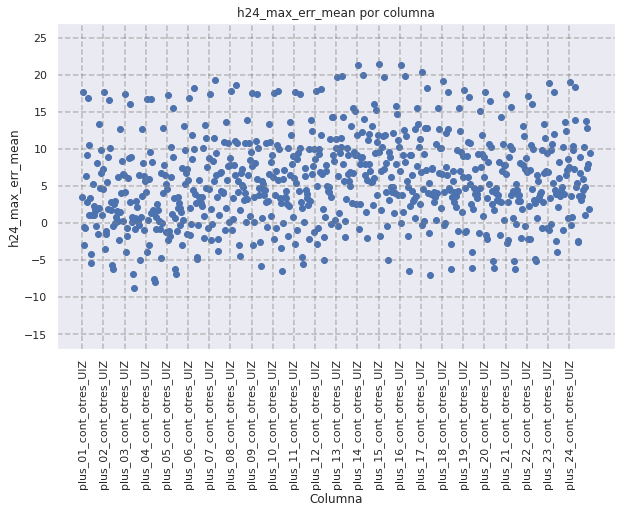

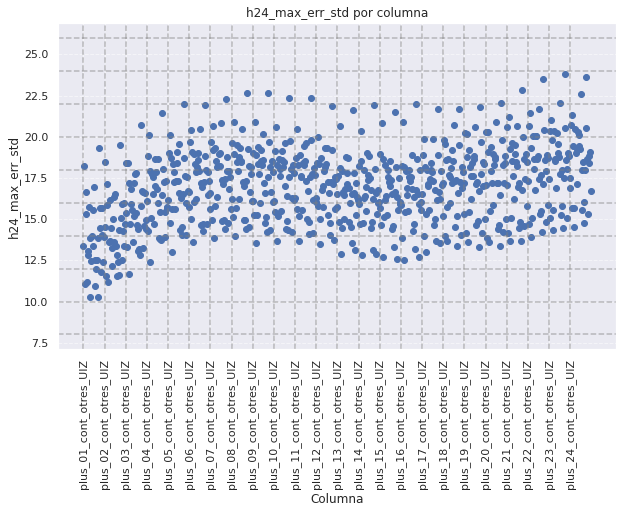

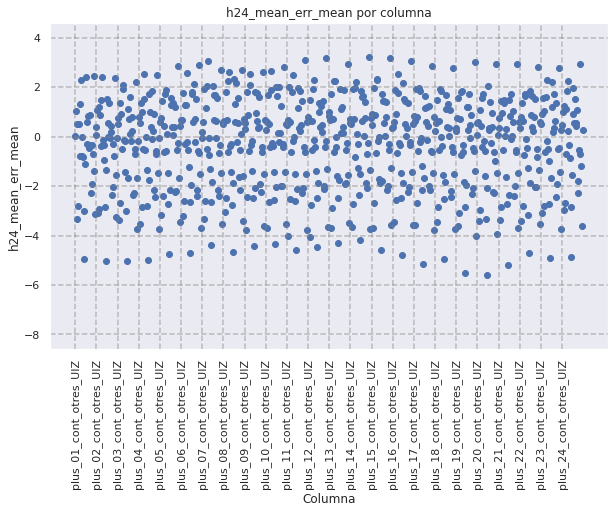

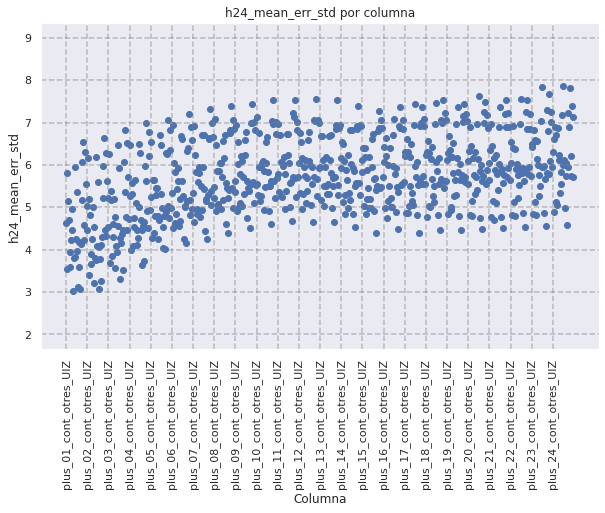

In [45]:
scatter_plot_by_column(results_df, 'h24_max_err_mean',
                output_results_folder_img)
scatter_plot_by_column(results_df, 'h24_max_err_std',
                output_results_folder_img)
scatter_plot_by_column(results_df, 'h24_mean_err_mean',
                output_results_folder_img)
scatter_plot_by_column(results_df, 'h24_mean_err_std',
                output_results_folder_img)

Promedio general de h24_max_err_mean sobre todas las estaciones: 5.6233


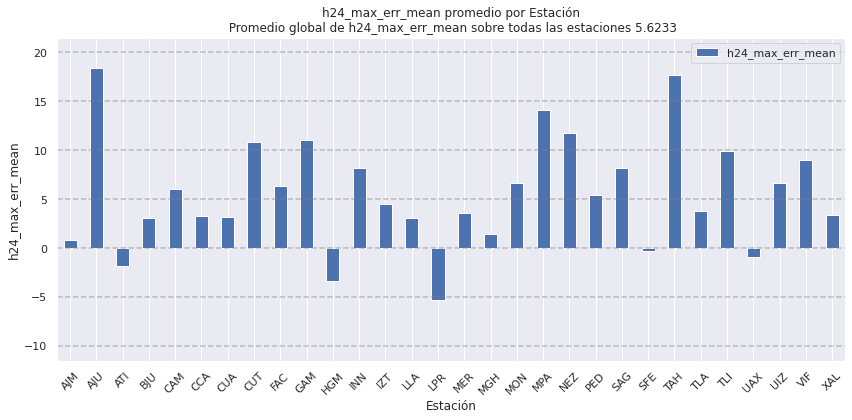

Promedio general de h24_max_err_std sobre todas las estaciones: 16.9372


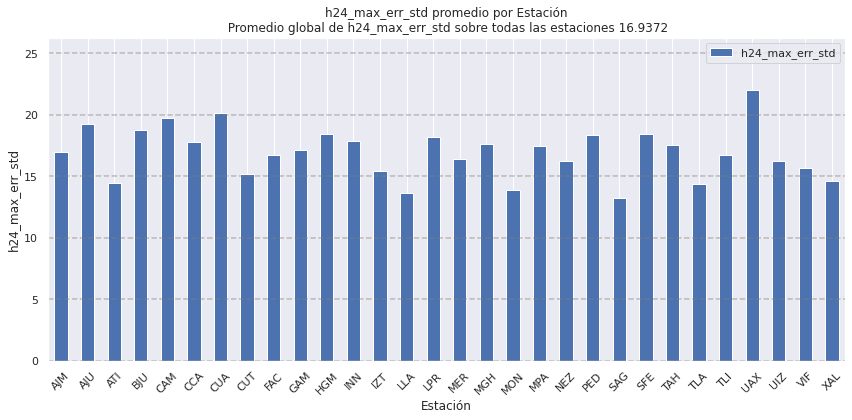

Promedio general de h24_mean_err_mean sobre todas las estaciones: -0.3575


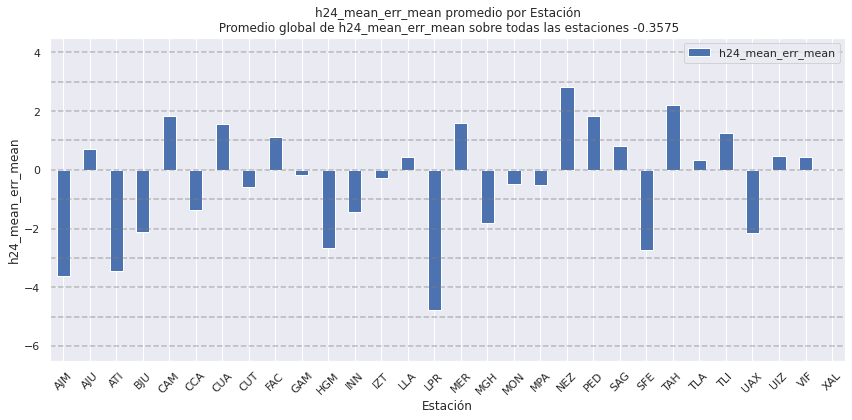

Promedio general de h24_mean_err_std sobre todas las estaciones: 5.7243


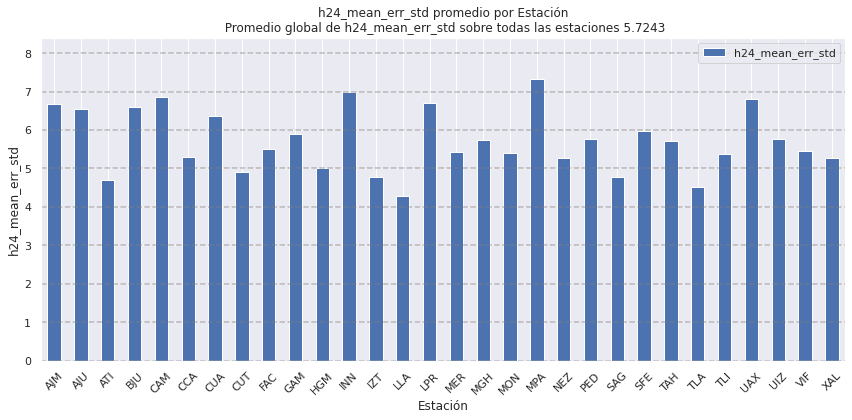

In [46]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Tu código aquí callando warnings
    average_metric(results_df, 'h24_max_err_mean', output_results_folder_img)
    average_metric(results_df, 'h24_max_err_std', output_results_folder_img)
    average_metric(results_df, 'h24_mean_err_mean', output_results_folder_img)
    average_metric(results_df, 'h24_mean_err_std', output_results_folder_img)

Promedio general de h24_max_err_mean sobre todas las horas: 5.6233


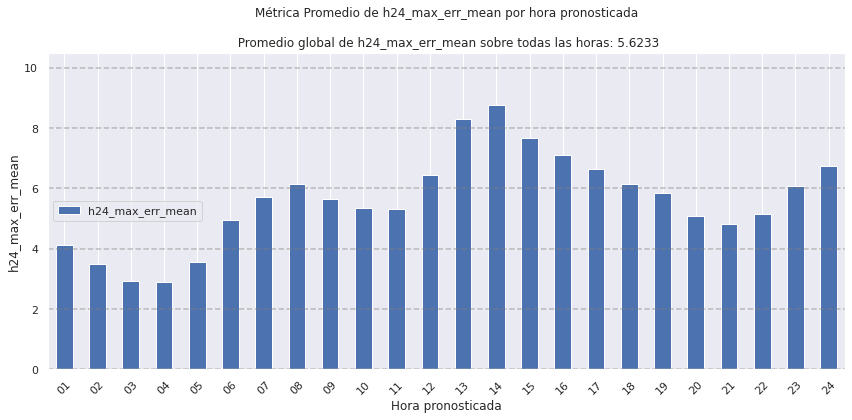

Promedio general de h24_max_err_std sobre todas las horas: 16.9372


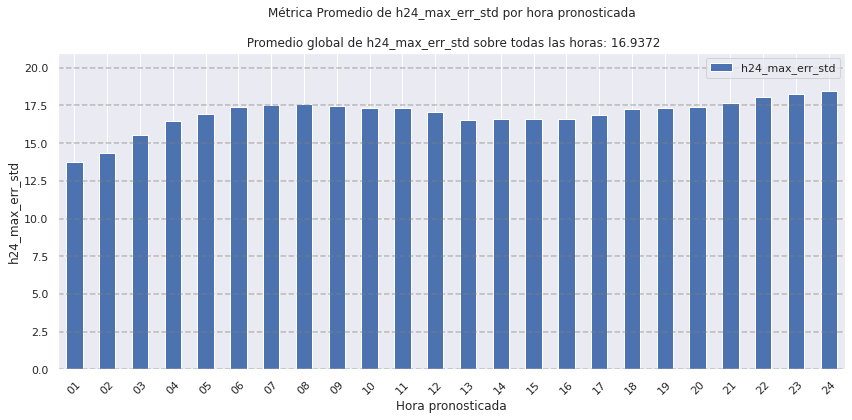

Promedio general de h24_mean_err_mean sobre todas las horas: -0.3575


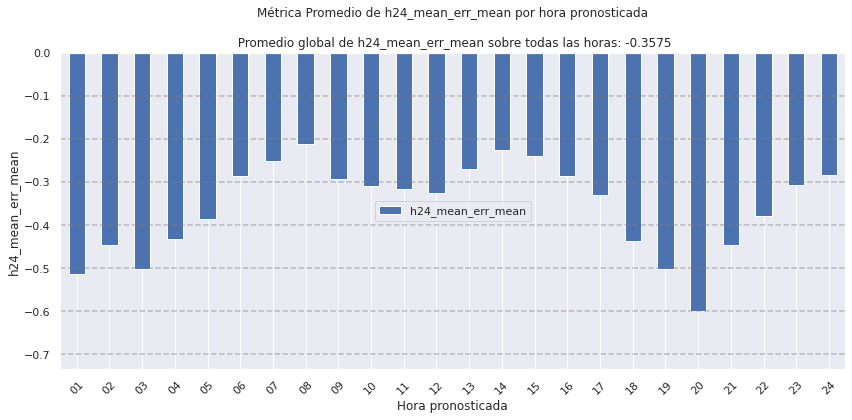

Promedio general de h24_mean_err_std sobre todas las horas: 5.7243


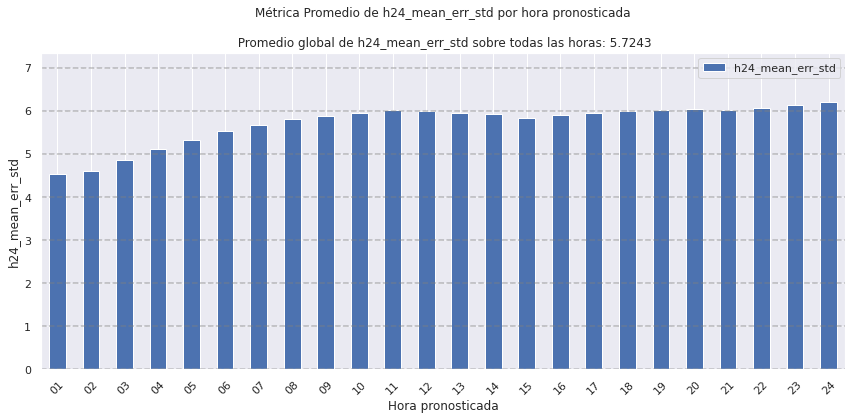

In [47]:

#with warnings.catch_warnings():
#    warnings.simplefilter("ignore")
    # Tu código aquí callando warnings
average_metric_by_hour(results_df, 'h24_max_err_mean', output_results_folder_img)
average_metric_by_hour(results_df, 'h24_max_err_std', output_results_folder_img)
average_metric_by_hour(results_df, 'h24_mean_err_mean', output_results_folder_img)
average_metric_by_hour(results_df, 'h24_mean_err_std', output_results_folder_img)

In [48]:
for index, row in results_df.iterrows():
    print(row)

Columna                  plus_01_cont_otres_UIZ
Índice de correlación                  0.935202
MAE                                    7.211486
MAPE                       383603879538196.5625
MSE                                   89.275782
RMSE                                   9.448586
R2                                     0.868284
Index of agreement                     0.960661
h24_max_err_mean                       3.593998
h24_max_err_std                       13.371078
h24_mean_err_mean                      0.015693
h24_mean_err_std                       4.624591
Name: 0, dtype: object
Columna                  plus_01_cont_otres_AJU
Índice de correlación                  0.902606
MAE                                   11.371191
MAPE                      256470246813604.53125
MSE                                  211.629088
RMSE                                  14.547477
R2                                     0.690458
Index of agreement                     0.866771
h24_max_err_mean 

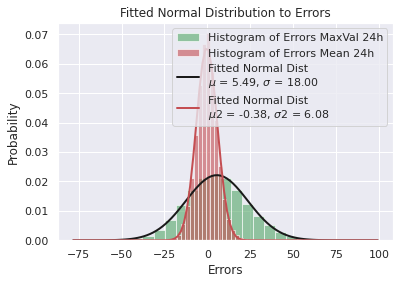

In [49]:
# Overall h24_max_err of the model

import numpy as np
from scipy.stats import norm
overall_errors = []

for columna, values in errors_dict.items():
    max_y_true = values['max_y_true']
    max_y_pred = values['max_y_pred']
    errors = max_y_true - max_y_pred

    for error in errors:
        if error != 0:
            overall_errors.append(error)

# into numpy array for easier treatment
overall_errors = np.array(overall_errors)

# Fit of normal distribution to max errors
mu, std = norm.fit(overall_errors)

# Histogram of the errors
plt.hist(overall_errors, bins=25, density=True, alpha=0.6, color='g', label="Histogram of Errors MaxVal 24h")

# PDF of the normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
overall_errors2 = []

for columna, values in errors_dict.items():
    max_y_true = values['mean_y_true']
    max_y_pred = values['mean_y_pred']
    errors = max_y_true - max_y_pred
    # Filtering zeros
    for error in errors:
        if error != 0:
            overall_errors2.append(error)

overall_errors2 = np.array(overall_errors2)
plt.hist(overall_errors2, bins=25, density=True, alpha=0.6, color='r', label="Histogram of Errors Mean 24h")

mu2, std2 = norm.fit(overall_errors2)
p2 = norm.pdf(x, mu2, std2)


plt.plot(x, p, 'k', linewidth=2, label=f"Fitted Normal Dist\n$\mu$ = {mu:.2f}, $\sigma$ = {std:.2f}")
plt.plot(x, p2, 'r', linewidth=2, label=f"Fitted Normal Dist\n$\mu2$ = {mu2:.2f}, $\sigma2$ = {std2:.2f}")


plt.xlabel("Errors")

plt.ylabel("Probability")

plt.title("Fitted Normal Distribution to Errors")

plt.legend()

plt.show()

#mean_np, std_np, mu, std